# Sessions

Builds a library of all individual sessions, where every session is categorized with properties for data extraction and classification.

![title](session.png)

## TODO

- Switch from JSON storage to Pandas Dataframe because JSON cannot handle datetime objects, and it is going to be so much more complicated having to parse string datetimes all over again

- New plan is to move forward with constructing SESSIONS one at a time. Use this notebook and create a new group of cells for every date (Q: is it possible to place code blocks in toggles to hide contents under a date?) Take one date at a time and reconstruct all sessions within that date. Sessions are the first step in organizing our data - it makes sure we have how everything happened straight. Then we need to place these sessions with associated station-PM2.5 values in a standardized format we can run our analysis on.

- The next step is then to convert the dictionary in python into a pandas dataframe-chunk for that session will all meta-information. The best structure for these dataframes have not yet been considered. 

- THINK: what is the end goal here? What do we want to be able to do? Work backwards from now on and meet in the middle. A lot of code is already in place. Q: what if we do not know the end goal yet?




### To fix
- remove route
- standard offset on all stations

station timestamp sensor pm
Alvik   09:08:30.   1.    0.9
Alvik.  09:08:31.   1.    0.92
...
Alvik   09:08:30.   2.    0.9
Alvik.  09:08:31.   2.    0.92
...
...
Alvik   09:08:30.   6.    0.9
Alvik.  09:08:31.   6.    0.92
...

station_chunk --> session_chunk (MÅL!)

In [3]:
################################
# LIBRARIES
################################
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import json
import pandas as pd
from datetime import datetime, timedelta
import os
import json

from src.util import *

plt.style.use("seaborn")

params = {
    "font.family": "STIXGeneral",
    "mathtext.fontset": "stix",
    "axes.labelsize": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "text.usetex": False,
    "figure.figsize": [10, 5],
    "axes.grid": True,
}

plt.rcParams.update(params)
plt.close("all")

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
################################
# HELPER FUNCTIONS
################################

def load_sessions(filename):
    with open(filename, 'r') as f:     
        sessions = json.loads(f.read())
        
    return sessions

def save_sessions(filename, sessions):
    with open(filename, 'w') as f:
        json.dump(sessions, f, default=str)

def get_placetime_df(pts_df, date, route, period):
    # Get data for that that date and period
    sub_df = pts_df[(pts_df['date'] == date) & (pts_df['period'] == period)]

    # Associate information
    pt_df = sub_df[(sub_df['route'] == route) & (sub_df['period'] == period)]
    pt_df = pt_df.sort_values('start')
    pt_df = pt_df.drop('mode', 1)
    
    return pt_df

def get_sensor_dfs(date, sensors, period):
    # Load data
    dfs = []
    labels = []

    dir_files = os.listdir(f'by-date-filtered/{date}/')
    data_files = []
    
    for file in dir_files:
        if (file[0] in sensors) and (file.endswith(f'{period}.csv')):
            data_files.append(file)

    data_files.sort()        

    # Add timestamps column
    for file in data_files:
        df = pd.read_csv(f'by-date-filtered/{date}/{file}', skiprows=1)
        df['Timestamp'] = df['Time'].apply(lambda x: format_time(x) + timedelta(hours=2))

        # Add label column
        df['Sensor'] = file[0]

        dfs.append(df)

        labels.append(file.split('-')[0])
        
    return dfs, labels, data_files

def plot_sensors(date, dfs, labels, pt_df, offsets = (0, 0), filename=None):
    # Plot to determine route
    fig, ax = plt.subplots(dpi=200, figsize = (10, 5))

    for i, df in enumerate(dfs):
        ax.plot(df['Timestamp'], df['PM2.5'], label=f'Sensor {labels[i]}')

    # Label axis
    ax.set_title(date, fontsize=25)
    ax.set_xlabel('time')
    ax.set_ylabel('PM 2.5')

    colors = ['k', 'm', 'b', 'g', 'c', 'y', 'darkorange', 'seagreen', 'royalblue', 'lightcoral', 'sandybrown', 'powderblue', 'violet', 'lawngreen', 'firebrick', 'khaki', 'darkmagenta']
    
    # Plot start and stop as vertical lines
    i = 0
    for index, row in pt_df.iterrows():
        
        # Check if lines need offsetting
        o1, o2 = offsets
        plt.axvline(x=get_timestamp(row['start'], date, o1), color=colors[i])
        plt.axvline(x=get_timestamp(row['stop'], date, o2), color=colors[i])
        
        i += 1
        
        ax.text(get_timestamp(row['start'], date), 25, row['station'], fontsize=12)

    # Format time on x-axis
    plt.gcf().autofmt_xdate()
    myFmt = dates.DateFormatter('%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(myFmt)
    
    if not filename == None:
        plt.savefig(filename)

    plt.show()
    
def get_station_chunks(date, station, start, stop, pt_df, sensor_dfs, offsets = (0, 0)):
    # Get station record
    s_df = pt_df[pt_df['station'] == station].iloc[0]
        
    # Get start and stop as time objects
    start = datetime.strptime(f'{date} {s_df["start"]}', '%Y-%m-%d %H:%M:%S')
    stop = datetime.strptime(f'{date} {s_df["stop"]}', '%Y-%m-%d %H:%M:%S')
    
    # Add offsets
    o1, o2 = offsets
    start += timedelta(seconds=o1)
    stop += timedelta(seconds=o2)
    
    # Get all records for sensor that falls within range
    station_chunks = []
    
    for s_df in sensor_dfs:
        filtered = s_df[(s_df['Timestamp'] >= start) & (s_df['Timestamp'] <= stop)]
        
        # Add date and station columns
        filtered['Station'] = station
        
        # Order columns in following order
        chunk = filtered[['Timestamp', 'Station', 'Sensor', 'Temperature', 'Humidity', 'NC0.5', 'NC1.0', 'NC2.5', 'NC10', 'TypicalParticleSize', 'PM1.0', 'PM2.5', 'PM4.0', 'PM10']]
        
        # Remove old index column
        chunk.reset_index(drop=True, inplace=True)
        
        # Add to total station chunks!
        station_chunks.append(chunk)
        
    return station_chunks

def get_session_chunk(date, start, stop, pt_df, sensor_dfs, offsets = (0, 0)):
    # Get station chunks
    o1, o2 = offsets

    # All station chunks
    session_chunks = []

    for index, row in pt_df.iterrows():
        start = get_timestamp(row['start'], row['date'], o1)
        stop = get_timestamp(row['stop'], row['date'], o2)

        # Get station dataframe and convert into arrays
        print(row['station'])
        station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)

        # Combine station_chunks into session chunk
        station_chunk = pd.concat(station_chunks)

        # Sort by column
        station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

        # Remove old index column
        station_chunk.reset_index(drop=True, inplace=True)

        session_chunks.append(station_chunk)

    # Combine
    session_chunk = pd.concat(session_chunks)

    # Sort by column
    #session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

    # Remove old index column
    session_chunk.reset_index(drop=True, inplace=True)

    session_chunk['Session Id'] = session_id
    
    return session_chunk

def populate_sensor_data(pt_df, session, offsets = (0, 0)):
    
    session['stations'] = {}
    
    for index, row in pt_df.iterrows():
        session['stations'][row['station']] = {}
        current = session['stations'][row['station']]
        
        # Add offsets
        o1, o2 = offsets
        
        current['start'] = get_timestamp(row['start'], row['date'], o1)
        current['stop'] = get_timestamp(row['stop'], row['date'], o2)

        # Get station dataframe and convert into arrays
        chunk = get_station_chunk(date, row['station'], current['start'], current['stop'], pt_df, sensor_dfs, (o1, o2))
        current['data'] = chunk.to_numpy()

In [5]:
################################
# SETUP
################################

# Global settings
OFFSETS = (30, -15)

# Load place csv
placetimes_df = pd.read_csv(f'../data/sessions/placetimes.csv')

# Load session json
sessions = load_sessions('../data/sessions/sessions.json')

In [6]:
placetimes_df.head(5)

date period       station     start      stop   route  mode
0  2021-09-29     PM  Abrahamsberg  17:58:50  18:05:13  Alicia   NaN
1  2021-09-29     PM         Alvik  17:50:31  17:52:16  Alicia   NaN
2  2021-09-29     PM    Brommaplan  18:06:53       NaN  Alicia   NaN
3  2021-09-29     PM  Fridhemsplan  17:38:45  17:40:14  Alicia   NaN
4  2021-09-29     AM    Gamla Stan  07:43:05  07:45:34   Alice   NaN

# ÅTERSTÅENDE
- 2021-09-22 SAKNAS STATIONER
- 2021-09-23 FLERA TÅG PÅ EN
- 2021-09-30 CHECK
- 2021-10-01 CHECK

## Template

## INSTRUCTIONAL GRAFER

In [49]:
####################### PARAMETERS

date = '2021-10-07'
period = 'AM'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': '123456',
}

fig_folder = 'figures/Instructionals'

####################### PARAMETERS

In [50]:
manual_rows = [
    [date, 'AM', 'Odenplan', '08:04:00', '08:06:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

df_rows

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

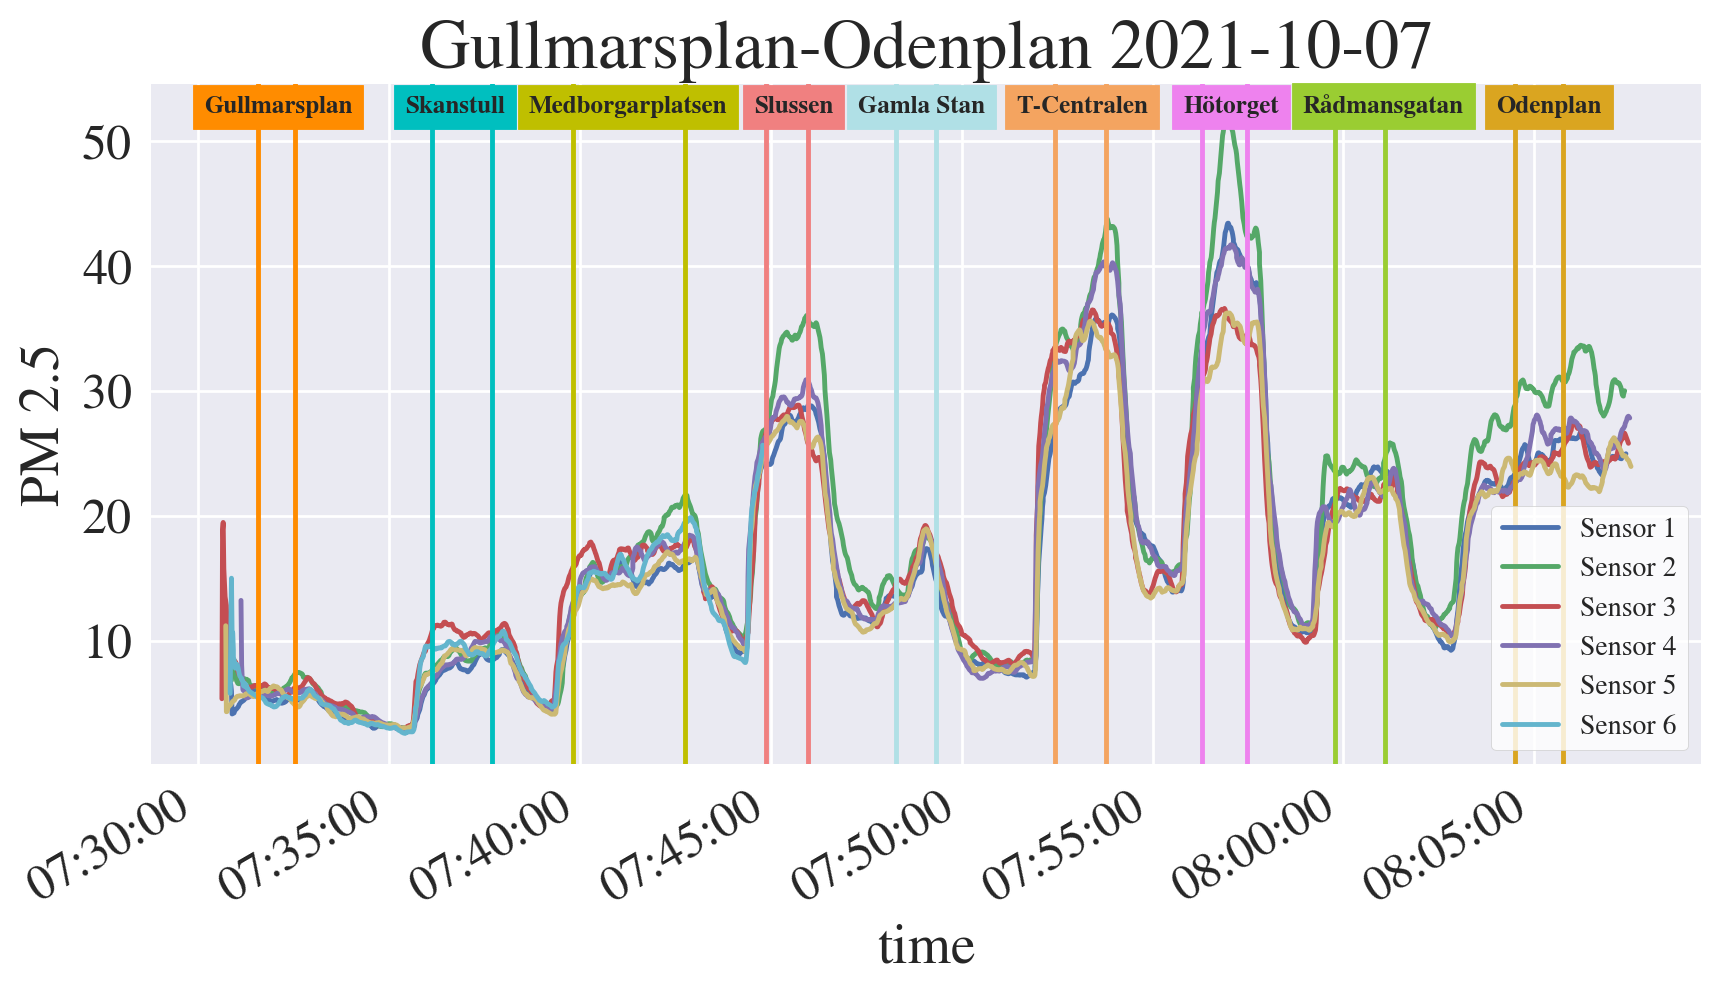

In [176]:
def plot_sensors_instructional(date, dfs, labels, pt_df, offsets = (0, 0), filename=None):
    # Plot to determine route
    fig, ax = plt.subplots(dpi=200, figsize = (10, 5))

    for i, df in enumerate(dfs):
        ax.plot(df['Timestamp'], df['PM2.5'], label=f'Sensor {labels[i]}')

    # Label axis
    ax.set_title(f'Gullmarsplan-Odenplan {date}', fontsize=25)
    ax.set_xlabel('time')
    ax.set_ylabel('PM 2.5')
    
    o = {s: 0 for s in set(list(pt_df['station']))}
    o['Gullmarsplan'] = -55
    o['Skanstull'] = -12
    o['Medborgarplatsen'] = -40
    o['Slussen'] = 10
    o['Gamla Stan'] = -30
    o['T-Centralen'] = -30
    o['Rådmansgatan'] = -20
    
    colors = ['darkorange', 'c', 'y', 'lightcoral', 'powderblue', 'sandybrown', 'violet', 'yellowgreen', 'goldenrod']
    
    # Plot start and stop as vertical lines
    i = 0
    for index, row in pt_df.iterrows():
        
        # Check if lines need offsetting
        o1, o2 = offsets
        plt.axvline(x=get_timestamp(row['start'], date, o1), color=colors[i])
        plt.axvline(x=get_timestamp(row['stop'], date, o2), color=colors[i])
        
        r = 0
        ax.text(get_timestamp(row['start'], date, o[row['station']]), 52.3, row['station'], fontsize=9, rotation=r, weight='bold', backgroundcolor=colors[i])
        
        i += 1   
    ax.legend(fontsize=10, loc=4, frameon=True, facecolor='#fff')
    
    # Format time on x-axis
    plt.gcf().autofmt_xdate()
    myFmt = dates.DateFormatter('%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(myFmt)
    
    if not filename == None:
        plt.savefig(filename)

    plt.show()

pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + 'step5' + '.pdf'
plot_sensors_instructional(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [458]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [459]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-09-24 09:38:42  Gullmarsplan      2         19.0      48.0   3.06   
1    2021-09-24 09:38:42  Gullmarsplan      B         19.6      45.4   2.72   
2    2021-09-24 09:38:43  Gullmarsplan      2         19.1      48.0   3.37   
3    2021-09-24 09:38:43  Gullmarsplan      B         19.7      45.4   2.87   
4    2021-09-24 09:38:44  Gullmarsplan      2         19.1      47.9   3.56   
...                  ...           ...    ...          ...       ...    ...   
5666 2021-09-24 10:50:43      Odenplan      B         27.3      37.5  58.16   
5667 2021-09-24 10:50:44      Odenplan      2         26.4      39.7  58.61   
5668 2021-09-24 10:50:44      Odenplan      B         27.3      37.5  57.94   
5669 2021-09-24 10:50:45      Odenplan      2         26.4      39.7  58.56   
5670 2021-09-24 10:50:45      Odenplan      B         27.3      37.5  57.67   

      NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0      3.56    3.57    3.57                 0.53   0.45   0.47   0.47   0.47   
1      3.15    3.16    3.16                 0.55   0.40   0.42   0.42   0.42   
2      3.93    3.93    3.94                 0.53   0.49   0.52   0.52   0.52   
3      3.31    3.32    3.33                 0.55   0.42   0.44   0.44   0.44   
4      4.15    4.16    4.16                 0.53   0.52   0.55   0.55   0.55   
...     ...     ...     ...                  ...    ...    ...    ...    ...   
5666  88.45  102.04  104.79                 1.10  12.89  26.36  36.66  38.72   
5667  99.98  120.77  124.93                 1.12  15.29  35.55  51.23  54.37   
5668  88.07  101.59  104.32                 1.10  12.83  26.22  36.46  38.51   
5669  99.71  120.37  124.49                 1.12  15.24  35.37  50.95  54.07   
5670  87.62  101.05  103.77                 1.10  12.76  26.07  36.24  38.28   

      Session Id  
0     20210924-1  
1     20210924-1  
2     20210924-1  
3     20210924-1  
4     20210924-1  
...          ...  
5666  20210924-1  
5667  20210924-1  
5668  20210924-1  
5669  20210924-1  
5670  20210924-1  

[5671 rows x 15 columns]

## NÄSTA 2021-09-22 ALICIA ROWS

In [16]:
####################### PARAMETERS

date = '2021-09-22'
period = 'PM'

session_id = ''.join(date.split('-')) + '-1'

session = {
    'date': date,
    'route': 'Alicia',
    'sensors': '1234BD',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [17]:
manual_rows = [
    #[date, 'AM', 'Odenplan', '10:48:00', '10:51:00', 'Alice', ''],
    #[date, 'PM', 'Odenplan', '18:12:00', '18:15:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

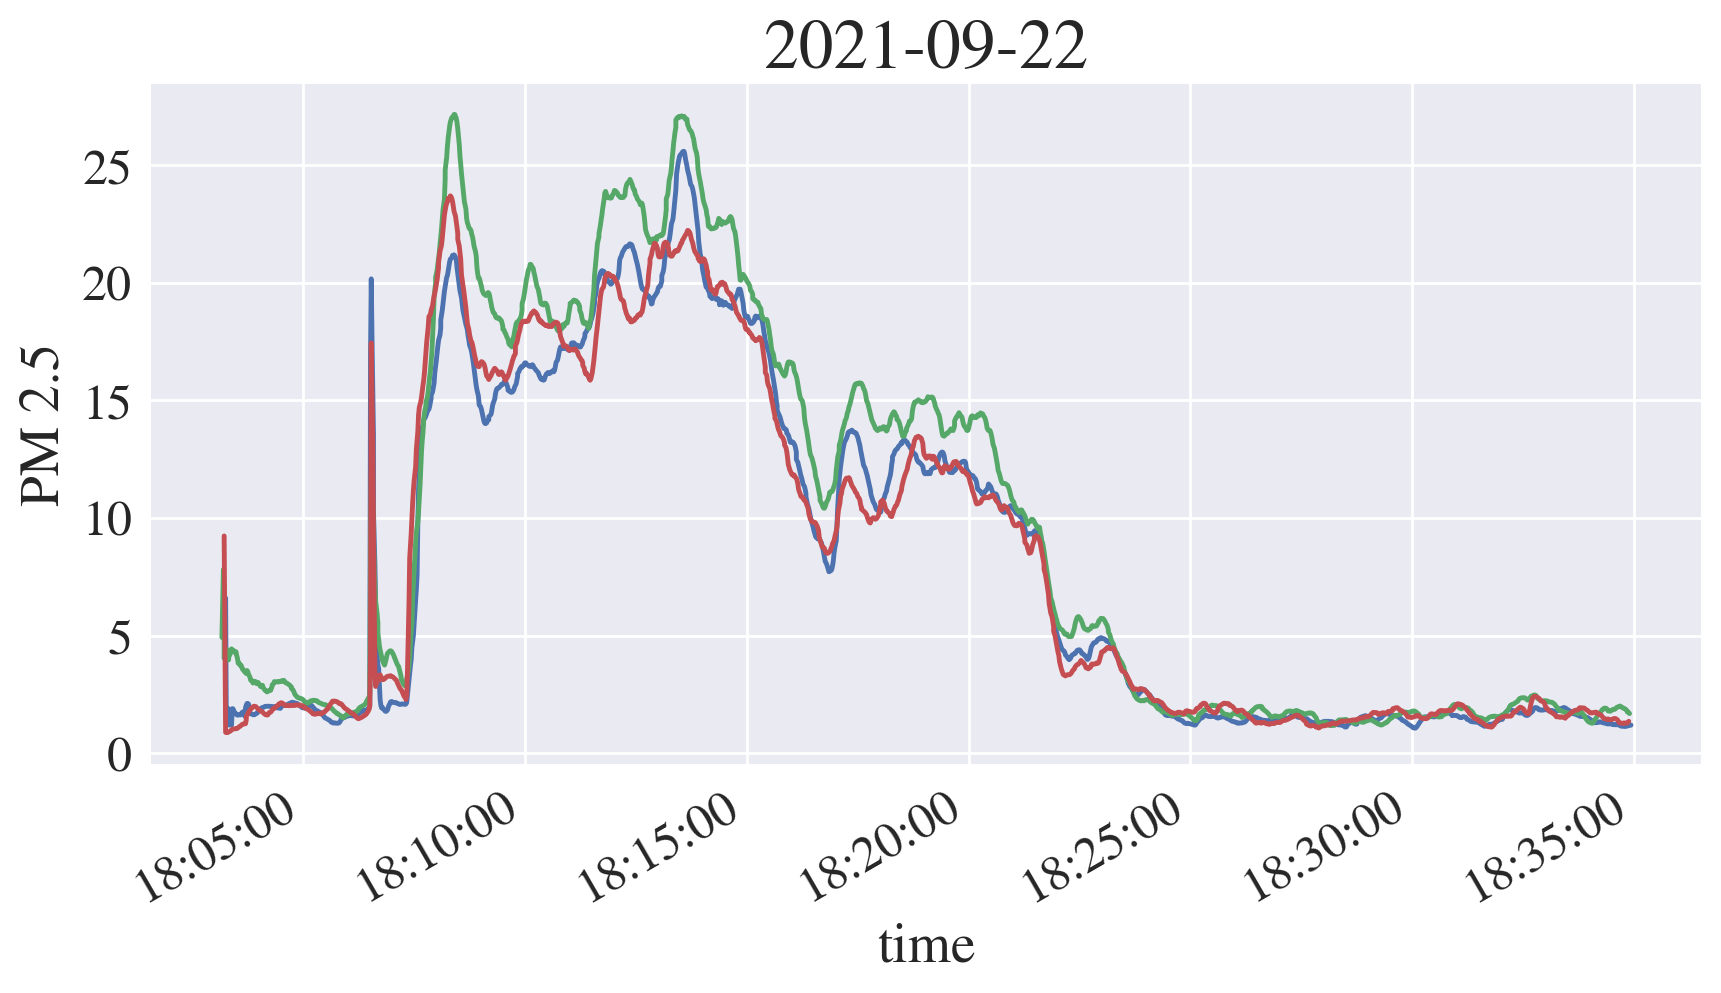

In [18]:
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
#pt_df = pt_df.tail(-1)
#pt_df.loc[pt_df.station == 'Kristineberg', 'stop'] = get_timestamp('18:04:00', date).time()
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [458]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [459]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-09-24 09:38:42  Gullmarsplan      2         19.0      48.0   3.06   
1    2021-09-24 09:38:42  Gullmarsplan      B         19.6      45.4   2.72   
2    2021-09-24 09:38:43  Gullmarsplan      2         19.1      48.0   3.37   
3    2021-09-24 09:38:43  Gullmarsplan      B         19.7      45.4   2.87   
4    2021-09-24 09:38:44  Gullmarsplan      2         19.1      47.9   3.56   
...                  ...           ...    ...          ...       ...    ...   
5666 2021-09-24 10:50:43      Odenplan      B         27.3      37.5  58.16   
5667 2021-09-24 10:50:44      Odenplan      2         26.4      39.7  58.61   
5668 2021-09-24 10:50:44      Odenplan      B         27.3      37.5  57.94   
5669 2021-09-24 10:50:45      Odenplan      2         26.4      39.7  58.56   
5670 2021-09-24 10:50:45      Odenplan      B         27.3      37.5  57.67   

      NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0      3.56    3.57    3.57                 0.53   0.45   0.47   0.47   0.47   
1      3.15    3.16    3.16                 0.55   0.40   0.42   0.42   0.42   
2      3.93    3.93    3.94                 0.53   0.49   0.52   0.52   0.52   
3      3.31    3.32    3.33                 0.55   0.42   0.44   0.44   0.44   
4      4.15    4.16    4.16                 0.53   0.52   0.55   0.55   0.55   
...     ...     ...     ...                  ...    ...    ...    ...    ...   
5666  88.45  102.04  104.79                 1.10  12.89  26.36  36.66  38.72   
5667  99.98  120.77  124.93                 1.12  15.29  35.55  51.23  54.37   
5668  88.07  101.59  104.32                 1.10  12.83  26.22  36.46  38.51   
5669  99.71  120.37  124.49                 1.12  15.24  35.37  50.95  54.07   
5670  87.62  101.05  103.77                 1.10  12.76  26.07  36.24  38.28   

      Session Id  
0     20210924-1  
1     20210924-1  
2     20210924-1  
3     20210924-1  
4     20210924-1  
...          ...  
5666  20210924-1  
5667  20210924-1  
5668  20210924-1  
5669  20210924-1  
5670  20210924-1  

[5671 rows x 15 columns]

In [460]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## FLERA TÅG PÅ EN - SPECIAL 2021-09-23

In [49]:
####################### PARAMETERS

date = '2021-09-23'
period = 'PM'

session_id = ''.join(date.split('-')) + '-2'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': '1234BD',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [56]:
manual_rows = [
    [date, 'AM', 'Odenplan', '10:47:00', '10:56:00', 'Alice', ''],
    [date, 'AM', 'Rådmansgatan', '10:58:30', '11:05:30', 'Alice', ''],
    [date, 'AM', 'Hötorget', '11:08:00', '11:16:00', 'Alice', ''],
    [date, 'AM', 'T-Centralen', '11:18:00', '11:24:00', 'Alice', ''],
    [date, 'PM', 'Gamla stan', '15:24:00', '15:30:00', 'Alice', ''],
    [date, 'PM', 'Train1', '15:33:34', '15:34:23', 'Alice', ''],
    [date, 'PM', 'Slussen', '15:32:00', '15:39:00', 'Alice', ''],
    [date, 'PM', 'Train1', '15:33:34', '15:34:23', 'Alice', ''],
    [date, 'PM', 'Train2', '15:35:46', '15:36:39', 'Alice', ''],
    [date, 'PM', 'Train3', '15:38:38', '15:39:00', 'Alice', ''],
    [date, 'PM', 'Medborgarplatsen', '15:40:00', '15:44:00', 'Alice', ''],
    [date, 'PM', 'Skanstull', '15:46:00', '15:49:00', 'Alice', ''],
    [date, 'PM', 'Train1', '15:47:48', '15:48:29', 'Alice', ''],
    [date, 'PM', 'Train2', '15:49:20', '15:49:45', 'Alice', ''],
    #[date, 'PM', 'Odenplan', '18:12:00', '18:15:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

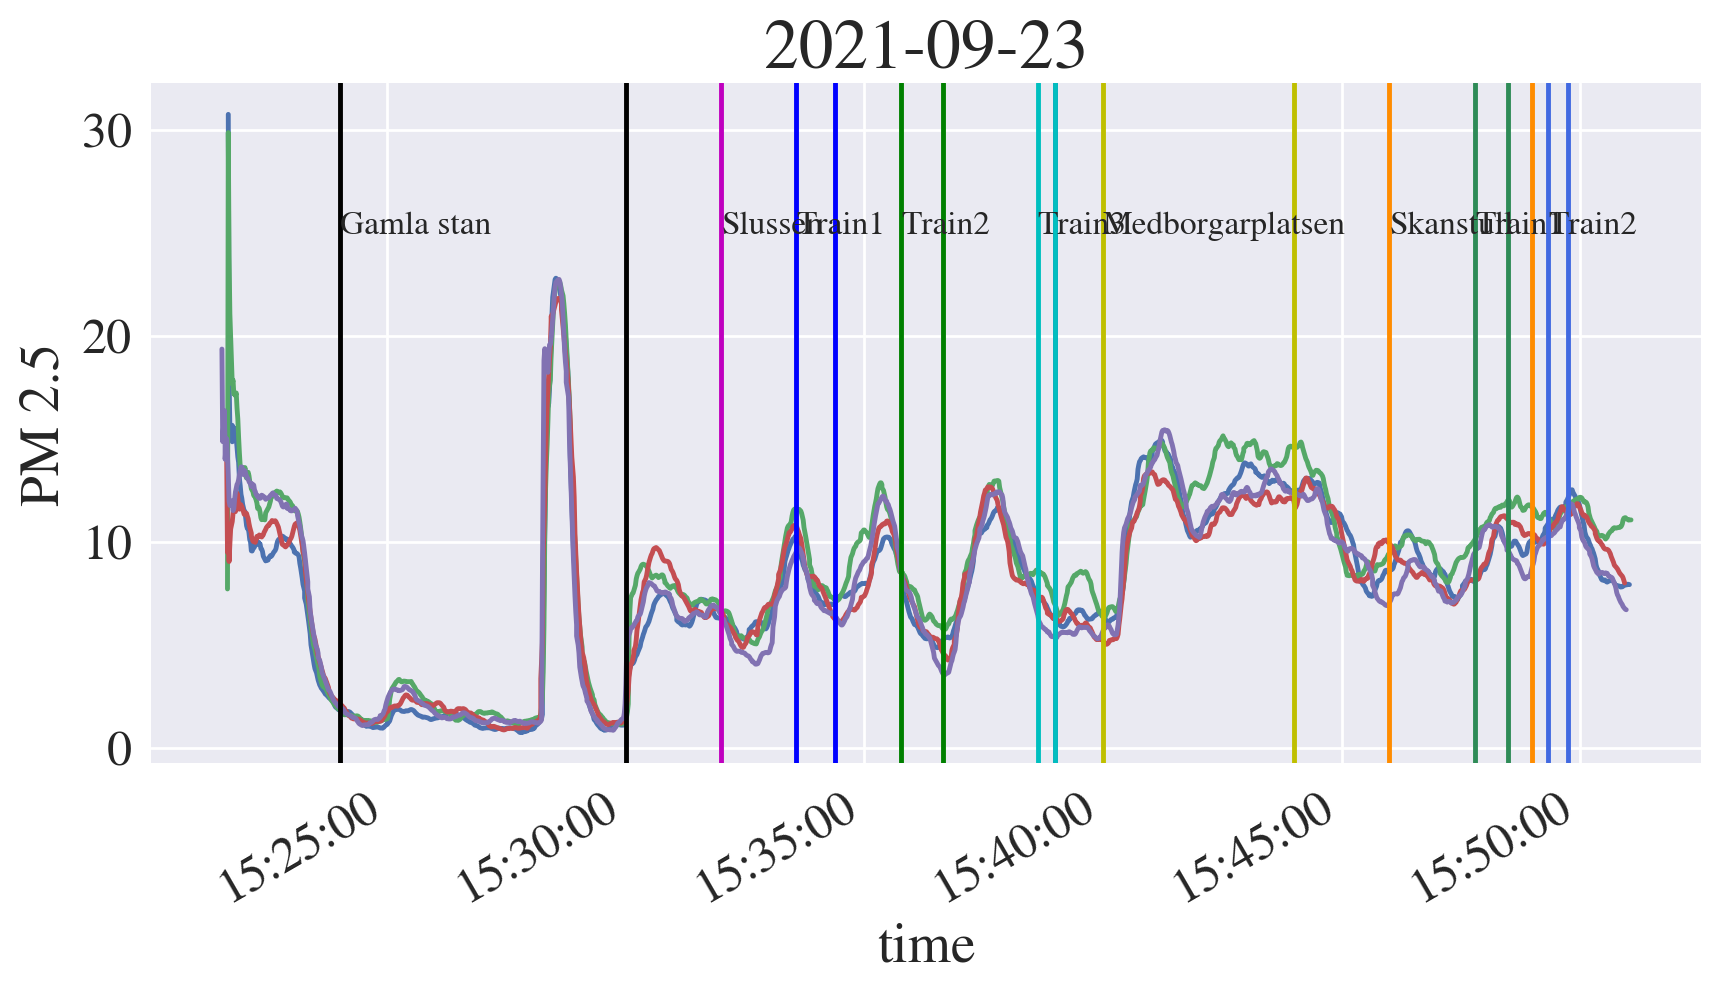

In [58]:
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
pt_df = pt_df[:-1]
#pt_df.loc[pt_df.station == 'Kristineberg', 'stop'] = get_timestamp('18:04:00', date).time()
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, (0, 0), filename)

Happy with the plot?

In [42]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [43]:
session_chunk

Timestamp      Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-09-23 10:47:30     Odenplan      1         24.9      57.4  65.26   
1    2021-09-23 10:47:30     Odenplan      2         24.8      57.4  73.98   
2    2021-09-23 10:47:31     Odenplan      2         24.8      57.4  74.23   
3    2021-09-23 10:47:31     Odenplan      3         24.8      57.0  69.02   
4    2021-09-23 10:47:32     Odenplan      1         24.9      57.4  65.24   
...                  ...          ...    ...          ...       ...    ...   
4541 2021-09-23 11:23:44  T-Centralen      2         27.2      46.9  71.95   
4542 2021-09-23 11:23:44  T-Centralen      3         28.2      43.8  72.02   
4543 2021-09-23 11:23:45  T-Centralen      1         27.9      45.0  66.40   
4544 2021-09-23 11:23:45  T-Centralen      2         27.2      46.8  72.64   
4545 2021-09-23 11:23:45  T-Centralen      3         28.2      43.7  72.32   

       NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0      93.00  104.37  106.70                 1.04  13.16  24.21  32.54  34.21   
1     109.86  125.50  128.63                 1.00  15.84  31.25  42.98  45.33   
2     110.08  125.68  128.79                 0.99  15.86  31.23  42.92  45.26   
3      93.84  102.93  104.77                 0.90  12.97  22.13  28.94  30.31   
4      93.00  104.39  106.73                 1.04  13.16  24.23  32.57  34.24   
...      ...     ...     ...                  ...    ...    ...    ...    ...   
4541  102.04  114.13  116.55                 0.93  14.39  26.39  35.42  37.23   
4542  100.84  112.17  114.46                 0.92  14.14  25.49  34.02  35.72   
4543   96.72  109.64  112.30                 1.04  13.83  26.34  35.82  37.72   
4544  103.04  115.26  117.70                 0.94  14.53  26.65  35.79  37.61   
4545  101.23  112.59  114.89                 0.91  14.19  25.57  34.12  35.83   

      Session Id  
0     20210923-1  
1     20210923-1  
2     20210923-1  
3     20210923-1  
4     20210923-1  
...          ...  
4541  20210923-1  
4542  20210923-1  
4543  20210923-1  
4544  20210923-1  
4545  20210923-1  

[4546 rows x 15 columns]

In [44]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR 2021-09-24

In [448]:
####################### PARAMETERS

date = '2021-09-24'
period = 'AM'

session_id = ''.join(date.split('-')) + '-1'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': '1234BD',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [456]:
manual_rows = [
    [date, 'AM', 'Odenplan', '10:48:00', '10:51:00', 'Alice', ''],
    #[date, 'PM', 'Odenplan', '18:12:00', '18:15:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

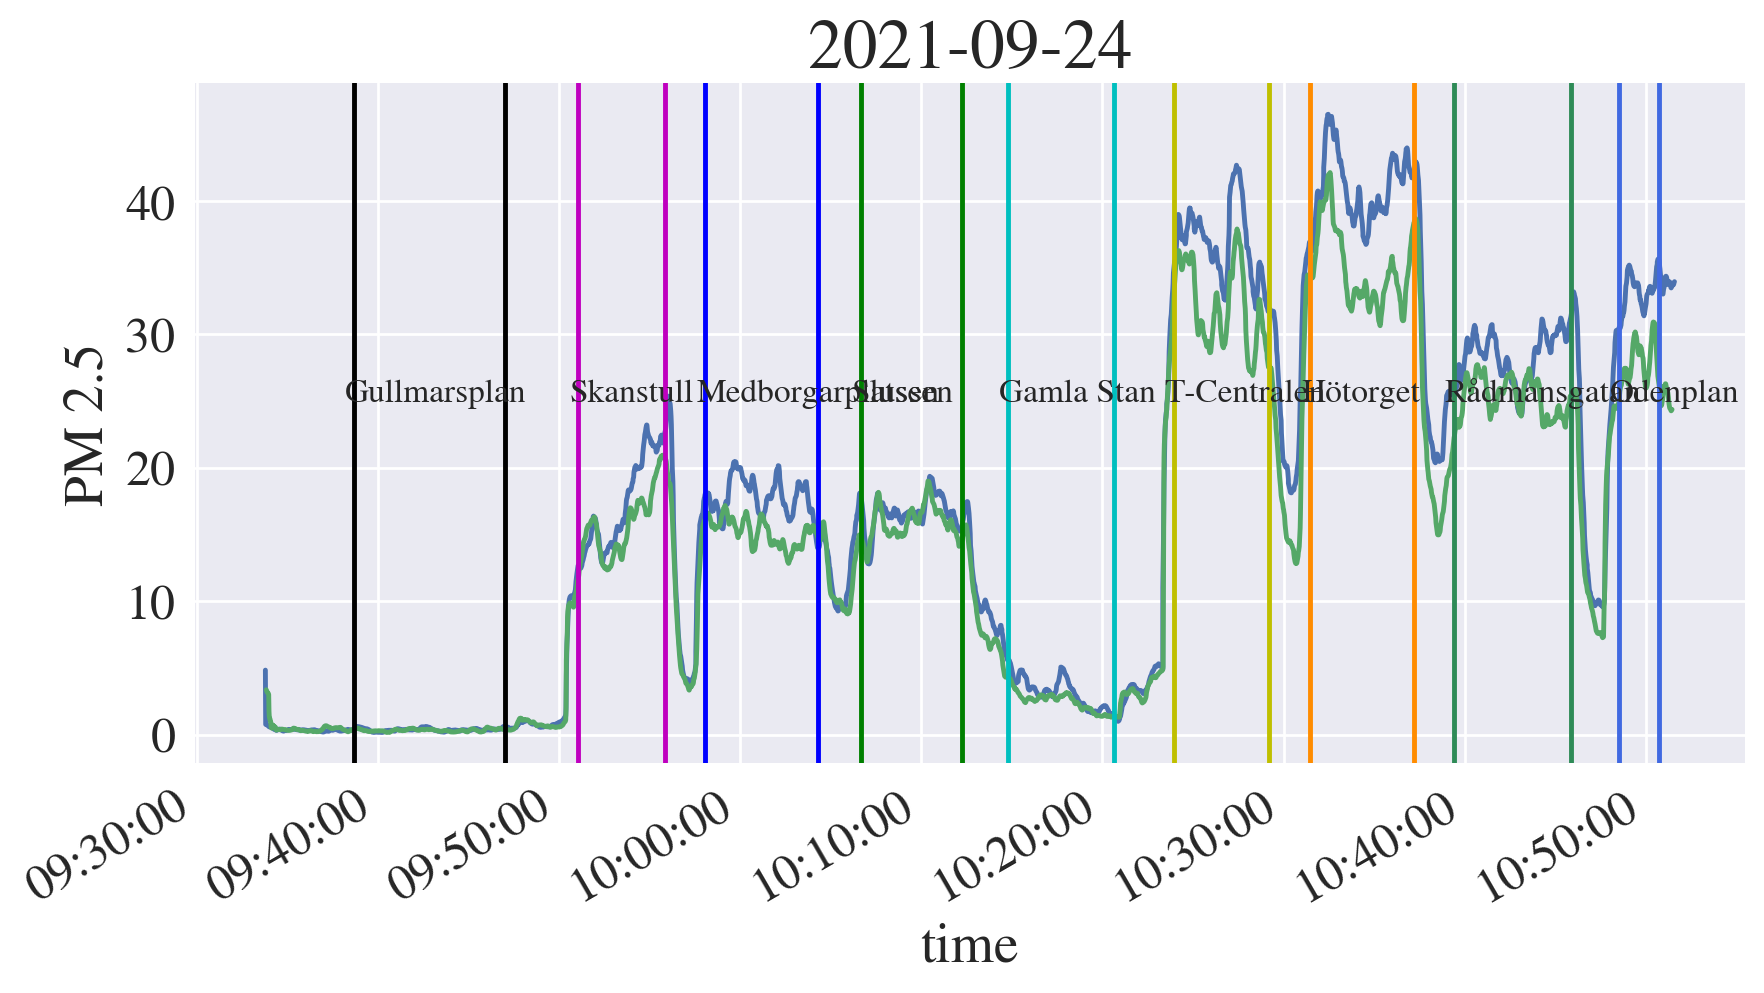

In [457]:
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
#pt_df.loc[pt_df.station == 'Kristineberg', 'stop'] = get_timestamp('18:04:00', date).time()
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [458]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [459]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-09-24 09:38:42  Gullmarsplan      2         19.0      48.0   3.06   
1    2021-09-24 09:38:42  Gullmarsplan      B         19.6      45.4   2.72   
2    2021-09-24 09:38:43  Gullmarsplan      2         19.1      48.0   3.37   
3    2021-09-24 09:38:43  Gullmarsplan      B         19.7      45.4   2.87   
4    2021-09-24 09:38:44  Gullmarsplan      2         19.1      47.9   3.56   
...                  ...           ...    ...          ...       ...    ...   
5666 2021-09-24 10:50:43      Odenplan      B         27.3      37.5  58.16   
5667 2021-09-24 10:50:44      Odenplan      2         26.4      39.7  58.61   
5668 2021-09-24 10:50:44      Odenplan      B         27.3      37.5  57.94   
5669 2021-09-24 10:50:45      Odenplan      2         26.4      39.7  58.56   
5670 2021-09-24 10:50:45      Odenplan      B         27.3      37.5  57.67   

      NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0      3.56    3.57    3.57                 0.53   0.45   0.47   0.47   0.47   
1      3.15    3.16    3.16                 0.55   0.40   0.42   0.42   0.42   
2      3.93    3.93    3.94                 0.53   0.49   0.52   0.52   0.52   
3      3.31    3.32    3.33                 0.55   0.42   0.44   0.44   0.44   
4      4.15    4.16    4.16                 0.53   0.52   0.55   0.55   0.55   
...     ...     ...     ...                  ...    ...    ...    ...    ...   
5666  88.45  102.04  104.79                 1.10  12.89  26.36  36.66  38.72   
5667  99.98  120.77  124.93                 1.12  15.29  35.55  51.23  54.37   
5668  88.07  101.59  104.32                 1.10  12.83  26.22  36.46  38.51   
5669  99.71  120.37  124.49                 1.12  15.24  35.37  50.95  54.07   
5670  87.62  101.05  103.77                 1.10  12.76  26.07  36.24  38.28   

      Session Id  
0     20210924-1  
1     20210924-1  
2     20210924-1  
3     20210924-1  
4     20210924-1  
...          ...  
5666  20210924-1  
5667  20210924-1  
5668  20210924-1  
5669  20210924-1  
5670  20210924-1  

[5671 rows x 15 columns]

In [460]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR 2021-09-27

In [496]:
####################### PARAMETERS

date = '2021-09-27'
period = 'PM'

session_id = ''.join(date.split('-')) + '-2'

session = {
    'date': date,
    'route': 'Alicia',
    'sensors': '1234BD',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [497]:
"""
Kristineberg: -18:04

Alvik: 18:06 - 18:08

Stora Mossen: 18:10-18:12

Abrahamnsberg: 18:14-18:16

Brommaplan: 18:18-18:20

Åkeshov: 18:22-18:24

Ängbyplan: 18:26-18:33

Islandstorget: 18:35-18:37

"""

manual_rows = [
    [date, 'AM', 'Odenplan', '07:50:00', '08:20:00', 'Alice', ''],
    [date, 'PM', 'Alvik', '18:06:00', '18:08:00', 'Alicia', ''],
    [date, 'PM', 'Stora mossen', '18:10:00', '18:12:00', 'Alicia', ''],
    [date, 'PM', 'Abrahamsberg', '18:14:00', '18:16:00', 'Alicia', ''],
    [date, 'PM', 'Brommaplan', '18:18:00', '18:20:00', 'Alicia', ''],
    [date, 'PM', 'Åkeshov', '18:21:30', '18:23:30', 'Alicia', ''],
    [date, 'PM', 'Ängbyplan', '18:26:00', '18:30:00', 'Alicia', ''],
    [date, 'PM', 'Islandstorget', '18:32:00', '18:35:00', 'Alicia', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

In [498]:
pt_df

date period        station     start      stop   route
1  2021-09-22     PM          Alvik  18:06:00  18:08:00  Alicia
2  2021-09-22     PM   Stora mossen  18:10:00  18:12:00  Alicia
3  2021-09-22     PM   Abrahamsberg  18:14:00  18:16:00  Alicia
4  2021-09-22     PM     Brommaplan  18:18:00  18:20:00  Alicia
5  2021-09-22     PM        Åkeshov  18:21:30  18:23:30  Alicia
6  2021-09-22     PM      Ängbyplan  18:26:00  18:30:00  Alicia
7  2021-09-22     PM  Islandstorget  18:32:00  18:35:00  Alicia

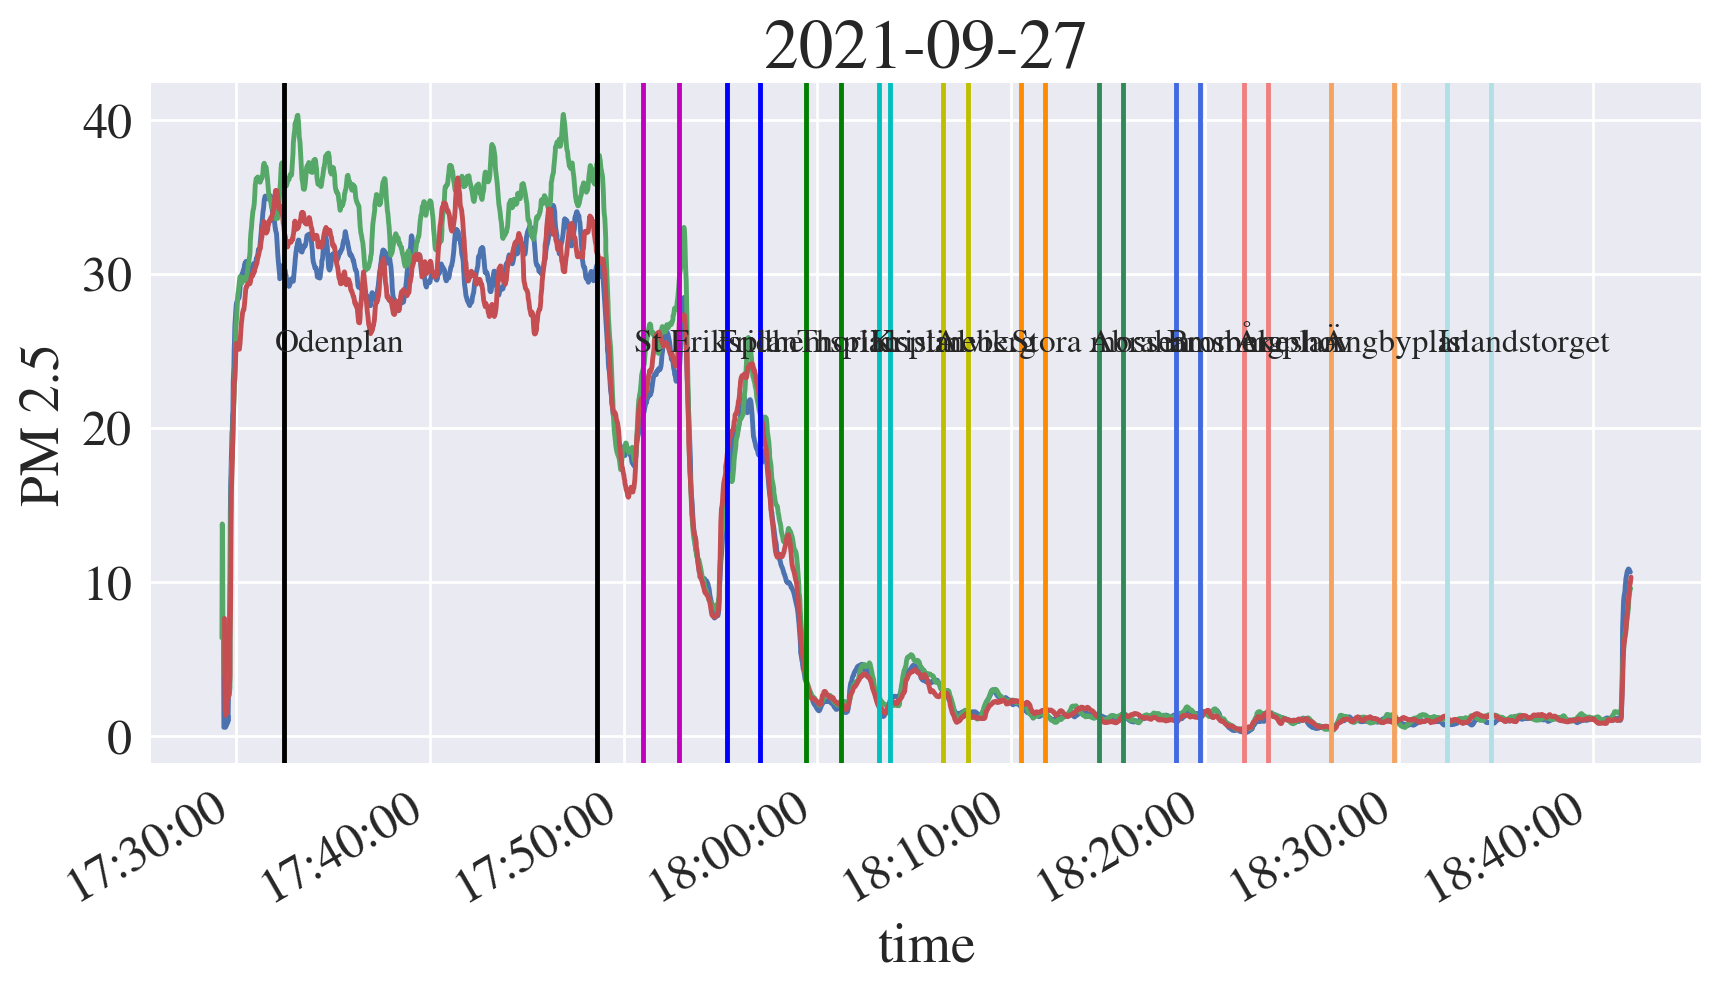

In [502]:
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
pt_df.loc[pt_df.station == 'Kristineberg', 'stop'] = get_timestamp('18:04:00', date).time()
pt_df.loc[pt_df.station == 'Odenplan', 'start'] = get_timestamp('17:32:00', date).time()
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [503]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [504]:
session_chunk

Timestamp        Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-09-27 17:32:30       Odenplan      2         22.7      49.2  78.69   
1    2021-09-27 17:32:30       Odenplan      B         22.6      48.8  74.78   
2    2021-09-27 17:32:31       Odenplan      1         22.7      49.3  68.83   
3    2021-09-27 17:32:31       Odenplan      2         22.8      49.2  78.10   
4    2021-09-27 17:32:31       Odenplan      B         22.6      48.8  74.34   
...                  ...            ...    ...          ...       ...    ...   
5707 2021-09-27 18:34:43  Islandstorget      B         23.5      43.4   8.67   
5708 2021-09-27 18:34:44  Islandstorget      1         23.6      44.3   5.97   
5709 2021-09-27 18:34:44  Islandstorget      2         22.8      45.9   8.41   
5710 2021-09-27 18:34:45  Islandstorget      1         23.7      44.1   5.94   
5711 2021-09-27 18:34:45  Islandstorget      B         23.4      43.4   8.63   

       NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0     120.66  139.77  143.59                 1.04  17.66  36.41  50.77  53.64   
1     112.33  128.93  132.29                 1.08  16.28  32.75  45.31  47.83   
2     103.80  119.47  122.69                 1.11  15.09  30.19  41.72  44.02   
3     119.87  138.90  142.70                 1.04  17.55  36.23  50.54  53.40   
4     111.70  128.21  131.55                 1.09  16.19  32.57  45.07  47.57   
...      ...     ...     ...                  ...    ...    ...    ...    ...   
5707   10.08   10.14   10.15                 0.59   1.27   1.37   1.39   1.40   
5708    6.91    6.93    6.93                 0.59   0.87   0.92   0.92   0.92   
5709    9.88    9.97    9.99                 0.56   1.25   1.38   1.43   1.44   
5710    6.88    6.90    6.91                 0.59   0.86   0.91   0.91   0.91   
5711   10.03   10.09   10.10                 0.59   1.26   1.36   1.39   1.39   

      Session Id  
0     20210927-2  
1     20210927-2  
2     20210927-2  
3     20210927-2  
4     20210927-2  
...          ...  
5707  20210927-2  
5708  20210927-2  
5709  20210927-2  
5710  20210927-2  
5711  20210927-2  

[5712 rows x 15 columns]

In [505]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR 2021-09-28

In [510]:
####################### PARAMETERS

date = '2021-09-28'
period = 'AM'

session_id = ''.join(date.split('-')) + '-2'

session = {
    'date': date,
    'route': 'Alicia',
    'sensors': '1234BD',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [511]:
placetimes_df.loc[(placetimes_df.station == 'Odenplan') & (placetimes_df.date == date)]

date period   station     start      stop   route  mode
193  2021-09-28     AM  Odenplan  11:06:00  11:11:44  Alicia   NaN

In [524]:
"""

Islandstorget: - 7:06

Ängbyplan: 7:08 - 7:10

Åkeshov: 7:12 - 7:15

Brommaplan: 7:17 - 7:20

Abrahamnsberg: 7:21 - 7:23

Stora Mossen: 7:24 - 7:26

Alvik: 7:28 - 7:31

Kristineberg: 7:33 - 7:36

Thorildsplan: --

Fridhemsplan: 7:39 - 7:42

St Eriksplan: 7:44 - 7:46

Odenplan: 8:00-8:05

"""

manual_rows = [
    [date, 'AM', 'Odenplan', '07:52:00', '08:15:00', 'Alicia', ''],
    [date, 'AM', 'St Eriksplan', '07:44:00', '07:46:00', 'Alicia', ''],
    [date, 'AM', 'Fridhemsplan', '07:39:00', '07:42:00', 'Alicia', ''],
    [date, 'AM', 'Kristineberg', '07:33:00', '07:36:00', 'Alicia', ''],
    [date, 'AM', 'Alvik', '07:28:00', '07:31:00', 'Alicia', ''],
    [date, 'AM', 'Stora mossen', '07:24:00', '07:26:00', 'Alicia', ''],
    [date, 'AM', 'Abrahamsberg', '07:21:00', '07:23:00', 'Alicia', ''],
    [date, 'AM', 'Brommaplan', '07:17:00', '07:20:00', 'Alicia', ''],
    [date, 'AM', 'Åkeshov', '07:12:00', '07:15:00', 'Alicia', ''],
    [date, 'AM', 'Ängbyplan', '07:08:00', '07:10:00', 'Alicia', ''],
    [date, 'AM', 'Islandstorget', '07:04:00', '07:06:00', 'Alicia', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

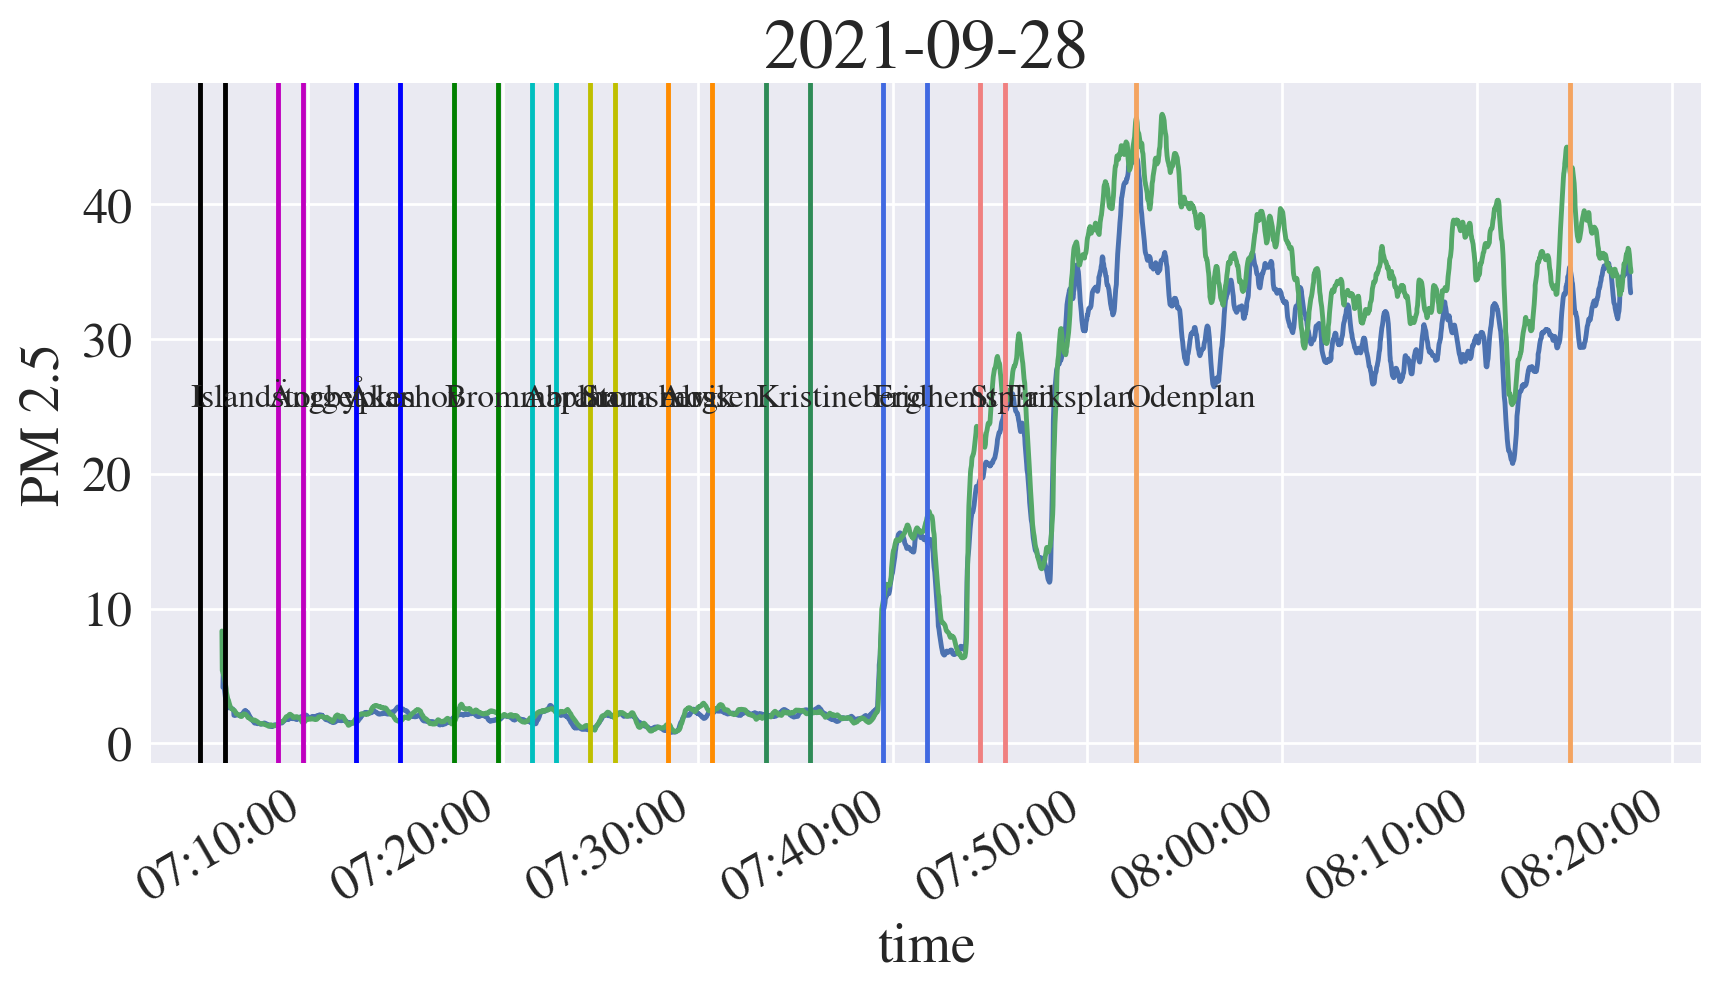

In [525]:
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
#pt_df.loc[pt_df.station == 'Odenplan', 'stop'] = get_timestamp('11:10:00', date).time()
pt_df = pt_df[:-6]
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], 'AM')
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [526]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [527]:
session_chunk

Timestamp        Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-09-28 07:05:36  Islandstorget      2         19.4      45.6  37.73   
1    2021-09-28 07:05:37  Islandstorget      2         19.5      45.6  34.94   
2    2021-09-28 07:05:38  Islandstorget      2         19.4      45.7  34.55   
3    2021-09-28 07:05:39  Islandstorget      1         19.6      45.2  26.95   
4    2021-09-28 07:05:39  Islandstorget      2         19.4      45.7  34.03   
...                  ...            ...    ...          ...       ...    ...   
4342 2021-09-28 08:14:43       Odenplan      1         27.7      35.8  78.32   
4343 2021-09-28 08:14:44       Odenplan      1         27.7      35.9  78.51   
4344 2021-09-28 08:14:44       Odenplan      2         26.7      38.0  91.73   
4345 2021-09-28 08:14:45       Odenplan      1         27.7      35.9  78.43   
4346 2021-09-28 08:14:45       Odenplan      2         26.7      38.0  90.82   

       NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0      46.90   48.96   49.37                 0.62   6.15   8.33   9.81  10.11   
1      40.66   40.76   40.78                 0.39   5.11   5.40   5.40   5.40   
2      40.21   40.31   40.33                 0.44   5.05   5.34   5.34   5.34   
3      31.23   31.30   31.32                 0.58   3.92   4.15   4.15   4.15   
4      39.61   39.71   39.73                 0.49   4.98   5.26   5.26   5.26   
...      ...     ...     ...                  ...    ...    ...    ...    ...   
4342  119.22  137.75  141.56                 1.10  17.40  35.25  48.89  51.62   
4343  119.53  138.11  141.94                 1.10  17.44  35.35  49.03  51.76   
4344  140.98  163.46  167.95                 1.05  20.65  42.71  59.61  62.99   
4345  119.38  137.94  141.76                 1.09  17.42  35.30  48.95  51.68   
4346  139.80  162.20  166.68                 1.06  20.49  42.47  59.31  62.68   

      Session Id  
0     20210928-2  
1     20210928-2  
2     20210928-2  
3     20210928-2  
4     20210928-2  
...          ...  
4342  20210928-2  
4343  20210928-2  
4344  20210928-2  
4345  20210928-2  
4346  20210928-2  

[4347 rows x 15 columns]

In [528]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR 2021-09-29 

In [356]:
####################### PARAMETERS

date = '2021-09-29'
period = 'PM'

session_id = ''.join(date.split('-')) + '-2'

session = {
    'date': date,
    'route': 'Alicia',
    'sensors': '1234BD',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [357]:
placetimes_df.loc[(placetimes_df.station == 'Odenplan') & (placetimes_df.date == date)]

date period   station     start      stop   route  mode
10  2021-09-29     AM  Odenplan  07:59:16  08:00:55  Alicia   NaN
11  2021-09-29     PM  Odenplan  17:28:48  17:31:52  Alicia   NaN

In [361]:
manual_rows = [
    #[date, 'PM', 'Odenplan', '08:04:00', '08:06:00', 'Alice', ''],
    #[date, 'PM', 'Odenplan', '18:12:00', '18:15:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

In [373]:
pt_df

date period       station     start      stop   route
11  2021-09-29     PM      Odenplan  17:28:48  17:31:52  Alicia
16  2021-09-29     PM  St Eriksplan  17:33:36  17:36:50  Alicia
3   2021-09-29     PM  Fridhemsplan  17:38:45  17:40:14  Alicia
20  2021-09-29     PM  Thorildsplan  17:43:13  17:43:53  Alicia
8   2021-09-29     PM  Kristineberg  17:45:11  17:48:21  Alicia
1   2021-09-29     PM         Alvik  17:50:31  17:52:16  Alicia
17  2021-09-29     PM  Stora mossen  17:54:42  17:57:30  Alicia
0   2021-09-29     PM  Abrahamsberg  17:58:50  18:05:13  Alicia
2   2021-09-29     PM    Brommaplan  18:06:53       NaN  Alicia
21  2021-09-29     PM       Åkeshov  18:10:58  18:12:01  Alicia

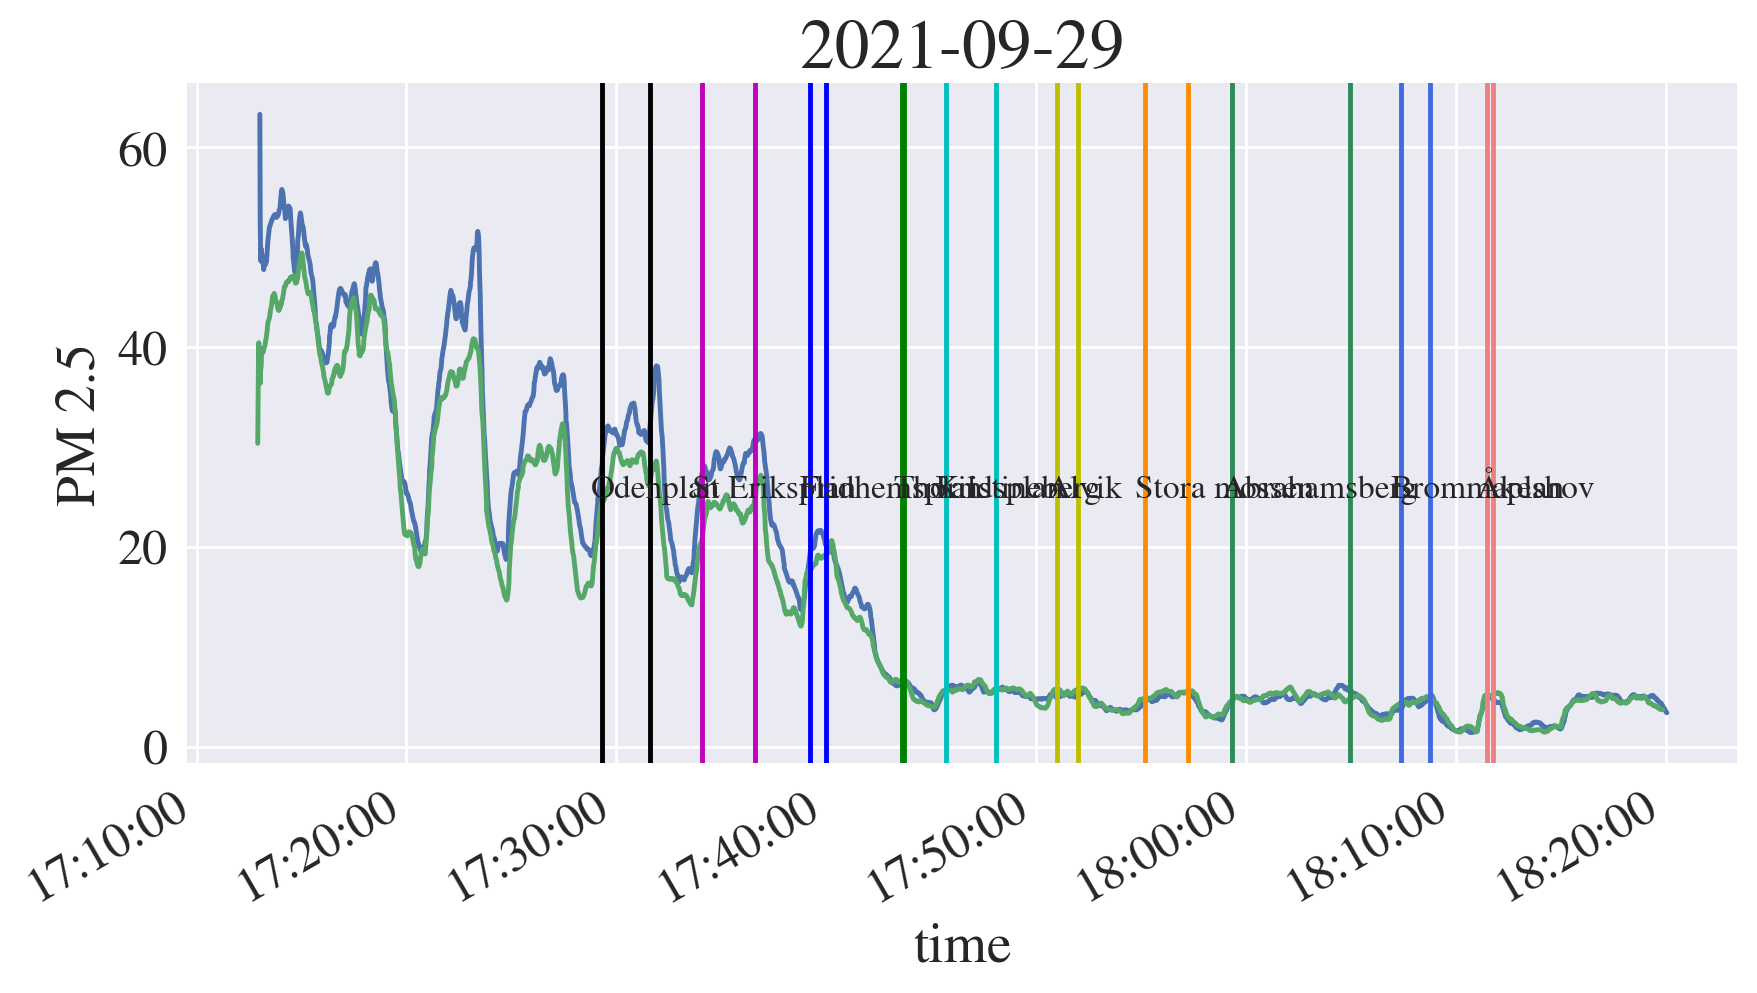

In [386]:
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
pt_df.loc[pt_df.station == 'Brommaplan', 'stop'] = get_timestamp('18:09:00', date).time()
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [387]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [388]:
session_chunk

Timestamp   Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-09-29 17:29:18  Odenplan      B         26.7      39.3  93.15   
1    2021-09-29 17:29:19  Odenplan      2         26.7      39.9  86.16   
2    2021-09-29 17:29:19  Odenplan      B         26.7      39.2  93.04   
3    2021-09-29 17:29:20  Odenplan      2         26.7      39.9  87.10   
4    2021-09-29 17:29:20  Odenplan      2         26.7      39.9  88.45   
...                  ...       ...    ...          ...       ...    ...   
2063 2021-09-29 18:11:44   Åkeshov      2         23.3      39.6  30.83   
2064 2021-09-29 18:11:44   Åkeshov      B         24.8      35.9  33.49   
2065 2021-09-29 18:11:45   Åkeshov      2         23.3      39.6  30.74   
2066 2021-09-29 18:11:46   Åkeshov      2         23.3      39.6  30.60   
2067 2021-09-29 18:11:46   Åkeshov      B         24.8      36.0  33.72   

       NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0     119.99  128.05  129.67                 0.86  16.10  24.39  30.34  31.53   
1     118.08  129.89  132.24                 0.93  16.36  28.16  36.95  38.71   
2     119.93  128.03  129.67                 0.86  16.10  24.43  30.41  31.61   
3     119.40  131.35  133.74                 0.92  16.55  28.49  37.39  39.17   
4     121.22  133.35  135.77                 0.91  16.80  28.92  37.94  39.75   
...      ...     ...     ...                  ...    ...    ...    ...    ...   
2063   35.94   36.06   36.09                 0.56   4.52   4.81   4.84   4.84   
2064   38.78   38.93   38.95                 0.59   4.88   5.19   5.21   5.21   
2065   35.83   35.95   35.97                 0.56   4.50   4.80   4.82   4.83   
2066   35.67   35.79   35.81                 0.56   4.48   4.78   4.80   4.81   
2067   39.05   39.19   39.22                 0.58   4.91   5.22   5.25   5.25   

      Session Id  
0     20210929-2  
1     20210929-2  
2     20210929-2  
3     20210929-2  
4     20210929-2  
...          ...  
2063  20210929-2  
2064  20210929-2  
2065  20210929-2  
2066  20210929-2  
2067  20210929-2  

[2068 rows x 15 columns]

In [389]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLART 2021-09-30

In [81]:
####################### PARAMETERS

date = '2021-09-30'
period = 'PM'

session_id = ''.join(date.split('-')) + '-3'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': '1234BD',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [82]:
manual_rows = [
    #[date, 'AM', 'Odenplan', '10:48:00', '10:51:00', 'Alice', ''],
    #[date, 'PM', 'Odenplan', '18:12:00', '18:15:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

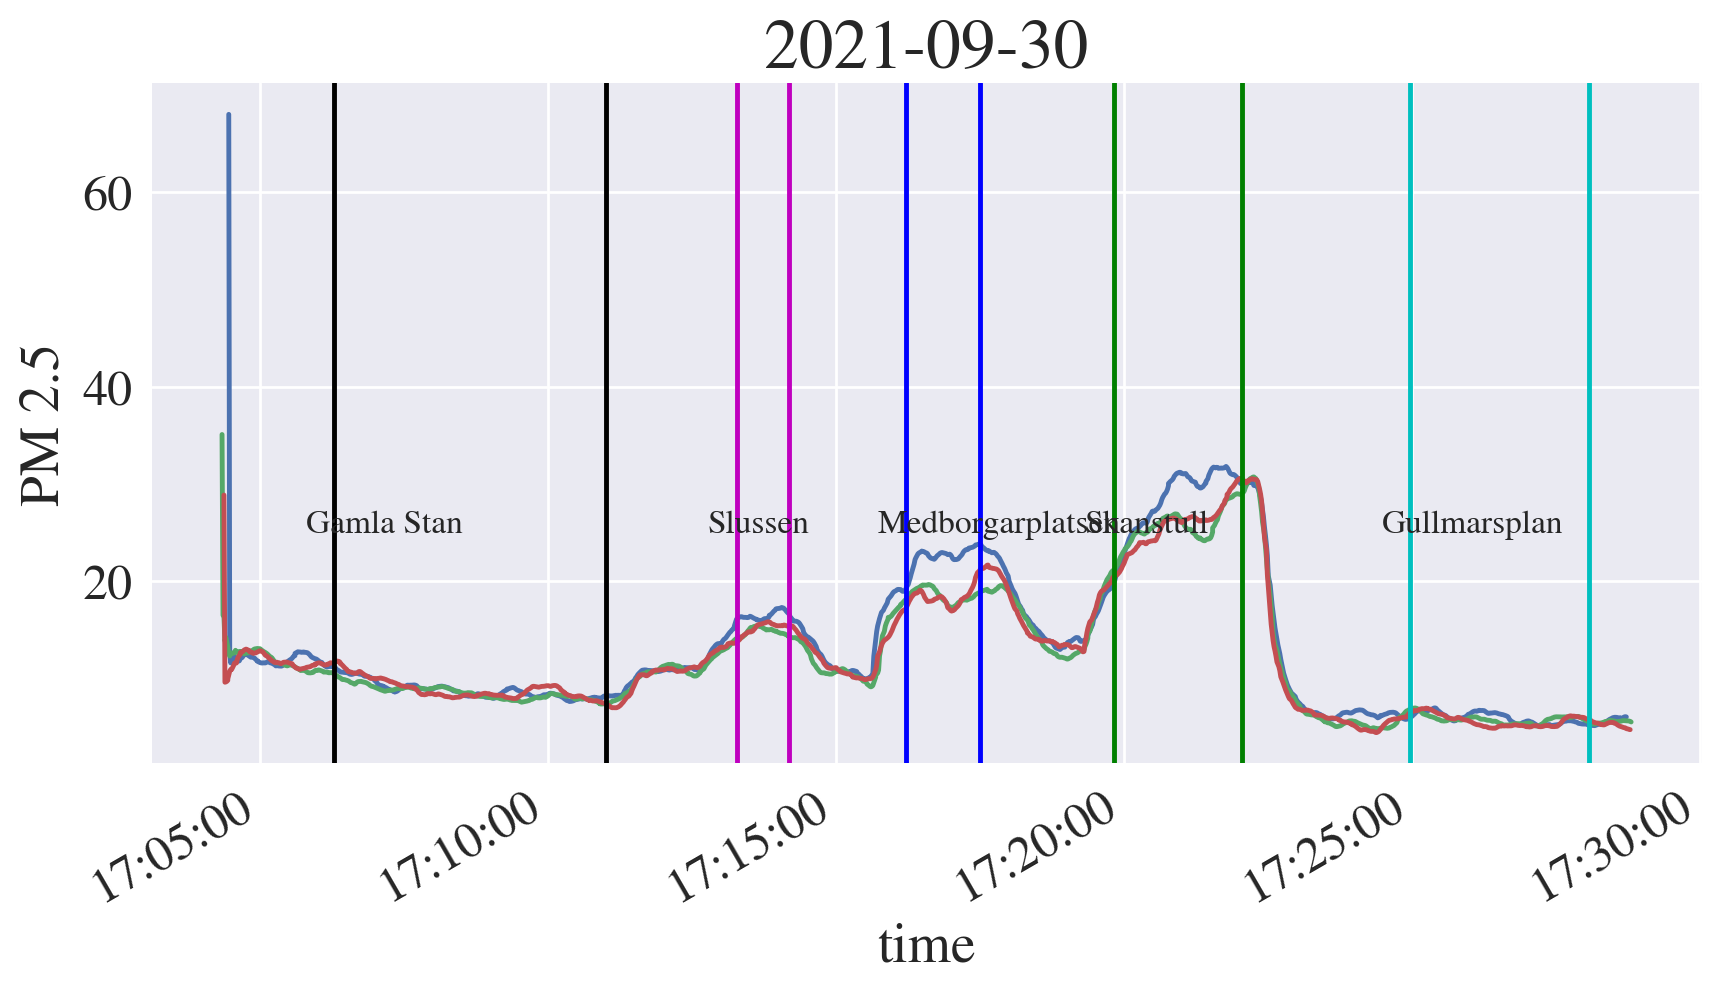

In [87]:
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
#pt_df = pt_df.head(3)
pt_df = pt_df.tail(-3)
#pt_df.loc[pt_df.station == 'Odenplan', 'start'] = get_timestamp('07:52:00', date).time()
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], 'PM2')
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [88]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [89]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-09-30 17:06:17    Gamla Stan      2         18.7      60.2  70.96   
1    2021-09-30 17:06:17    Gamla Stan      4         19.0      60.2  63.65   
2    2021-09-30 17:06:17    Gamla Stan      B         19.1      60.1  72.98   
3    2021-09-30 17:06:18    Gamla Stan      2         18.7      60.2  70.50   
4    2021-09-30 17:06:18    Gamla Stan      4         19.1      60.3  63.24   
...                  ...           ...    ...          ...       ...    ...   
2067 2021-09-30 17:28:03  Gullmarsplan      2         21.3      50.1  33.49   
2068 2021-09-30 17:28:03  Gullmarsplan      B         24.0      43.1  37.67   
2069 2021-09-30 17:28:04  Gullmarsplan      2         21.3      50.1  33.33   
2070 2021-09-30 17:28:04  Gullmarsplan      4         23.2      45.6  36.08   
2071 2021-09-30 17:28:04  Gullmarsplan      B         24.0      43.1  37.37   

      NC1.0  NC2.5   NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0     82.87  83.26  83.34                 0.60  10.43  11.21  11.35  11.38   
1     74.48  75.24  75.39                 0.61   9.43  10.49  10.90  10.98   
2     84.99  85.60  85.71                 0.62  10.73  11.69  11.96  12.02   
3     82.33  82.71  82.79                 0.59  10.37  11.13  11.27  11.30   
4     73.98  74.72  74.86                 0.61   9.37  10.40  10.81  10.89   
...     ...    ...    ...                  ...    ...    ...    ...    ...   
2067  39.06  39.21  39.24                 0.56   4.91   5.24   5.28   5.29   
2068  43.57  43.70  43.72                 0.53   5.48   5.79   5.79   5.79   
2069  38.87  39.02  39.05                 0.56   4.89   5.22   5.26   5.27   
2070  41.77  41.92  41.94                 0.56   5.25   5.58   5.60   5.60   
2071  43.23  43.36  43.38                 0.53   5.43   5.74   5.74   5.74   

      Session Id  
0     20210930-3  
1     20210930-3  
2     20210930-3  
3     20210930-3  
4     20210930-3  
...          ...  
2067  20210930-3  
2068  20210930-3  
2069  20210930-3  
2070  20210930-3  
2071  20210930-3  

[2072 rows x 15 columns]

In [90]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR 2021-10-01

In [201]:
####################### PARAMETERS

date = '2021-10-01'
period = 'PM'

session_id = ''.join(date.split('-')) + '-3'

session = {
    'date': date,
    'route': 'Alicia',
    'sensors': '1234B',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [202]:
placetimes_df.loc[(placetimes_df.station == 'Odenplan') & (placetimes_df.date == date)]

date period   station     start      stop   route  mode
203  2021-10-01     AM  Odenplan  09:50:30  09:56:17  Alicia   NaN
204  2021-10-01     PM  Odenplan  17:27:17  17:30:04  Alicia   NaN

In [203]:
manual_rows = [
    [date, 'AM', 'Slussen', '09:24:42', '09:27:00', 'Alice', ''],
    [date, 'AM', 'Gamla stan', '09:29:38', '09:33:00', 'Alice', ''],
    [date, 'AM', 'T-Centralen', '09:35:55', '09:39:00', 'Alice', ''],
    [date, 'AM', 'Hötorget', '09:40:57', '09:43:30', 'Alice', ''],
    [date, 'AM', 'Rådmansgatan', '09:45:11', '09:48:30', 'Alice', ''],
    [date, 'AM', 'Odenplan', '09:50:30', '09:56:00', 'Alice', ''],
    [date, 'AM', 'Rådmansgatan', '09:57:54', '10:01:00', 'Alice', ''],
    [date, 'AM', 'Hötorget', '10:02:35', '10:05:30', 'Alice', ''],
    [date, 'AM', 'T-Centralen', '10:07:24', '10:11:00', 'Alice', ''],
    [date, 'AM', 'Odenplan', '12:05:00', '12:27:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

In [204]:
pt_df.tail(0)

Empty DataFrame
Columns: [date, period, station, start, stop, route]
Index: []

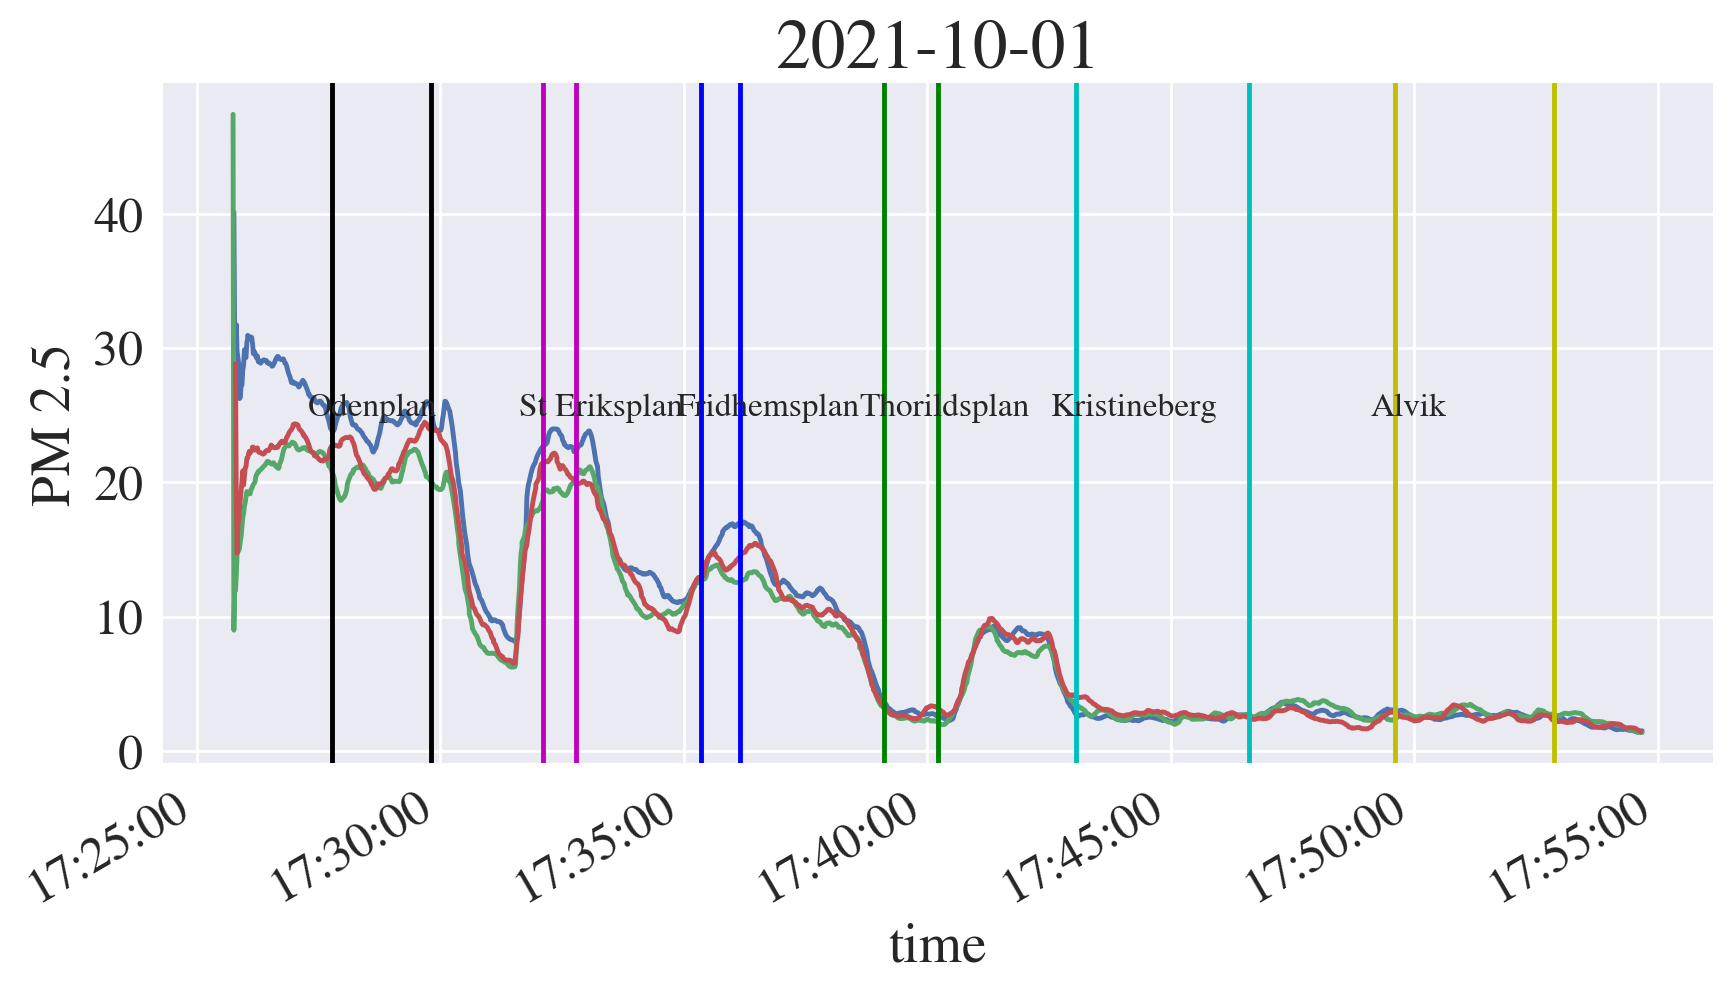

In [206]:
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
#pt_df.loc[pt_df.station == 'Rådmansgatan', 'stop'] = get_timestamp('12:02:00', date).time()
#pt_df = pt_df[:-5]
#pt_df = pt_df.head(5)
#pt_df = pt_df.tail(0)
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [207]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [208]:
session_chunk

Timestamp   Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-10-01 17:27:47  Odenplan      2         21.9      53.1  63.76   
1    2021-10-01 17:27:47  Odenplan      2         21.9      53.4  63.56   
2    2021-10-01 17:27:47  Odenplan      3         20.7      55.9  72.99   
3    2021-10-01 17:27:47  Odenplan      B         20.9      55.6  64.33   
4    2021-10-01 17:27:48  Odenplan      B         20.9      55.6  64.45   
...                  ...       ...    ...          ...       ...    ...   
1927 2021-10-01 17:52:51     Alvik      2         20.4      47.2  15.39   
1928 2021-10-01 17:52:51     Alvik      3         22.3      42.2  14.99   
1929 2021-10-01 17:52:51     Alvik      B         21.8      43.3  13.74   
1930 2021-10-01 17:52:52     Alvik      2         20.4      47.3  15.35   
1931 2021-10-01 17:52:52     Alvik      3         22.3      42.2  14.81   

      NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0     90.98  102.05  104.27                 0.94  12.87  23.84  32.13  33.78   
1     90.76  101.85  104.06                 0.94  12.84  23.83  32.12  33.78   
2     96.02  103.59  105.12                 0.82  13.04  20.75  26.38  27.51   
3     90.06  100.17  102.22                 0.99  12.63  22.76  30.37  31.89   
4     90.19  100.30  102.35                 0.98  12.64  22.77  30.38  31.90   
...     ...     ...     ...                  ...    ...    ...    ...    ...   
1927  18.19   18.41   18.45                 0.62   2.31   2.61   2.74   2.77   
1928  17.87   18.26   18.34                 0.66   2.29   2.74   3.00   3.05   
1929  16.12   16.31   16.34                 0.63   2.04   2.30   2.41   2.43   
1930  18.14   18.36   18.41                 0.62   2.30   2.60   2.74   2.76   
1931  17.65   18.04   18.11                 0.65   2.26   2.71   2.96   3.02   

      Session Id  
0     20211001-3  
1     20211001-3  
2     20211001-3  
3     20211001-3  
4     20211001-3  
...          ...  
1927  20211001-3  
1928  20211001-3  
1929  20211001-3  
1930  20211001-3  
1931  20211001-3  

[1932 rows x 15 columns]

In [209]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

In [ ]:
# Nu blir det special treatment + sensorer 1234BD! Vi behöver nog modifiera scriptet något

## KLAR 2021-10-04

In [24]:
####################### PARAMETERS

date = '2021-10-04'
period = 'PM'

session_id = ''.join(date.split('-')) + '-2'

session = {
    'date': date,
    'route': 'Alicia',
    'sensors': '123456',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [25]:
manual_rows = [
    [date, 'AM', 'Odenplan', '08:41:00', '08:43:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

df_rows

date period   station     start      stop  route mode
0  2021-10-04     AM  Odenplan  08:41:00  08:43:00  Alice

In [26]:
# Add to placetimes
placetimes_df = placetimes_df.append(df_rows)

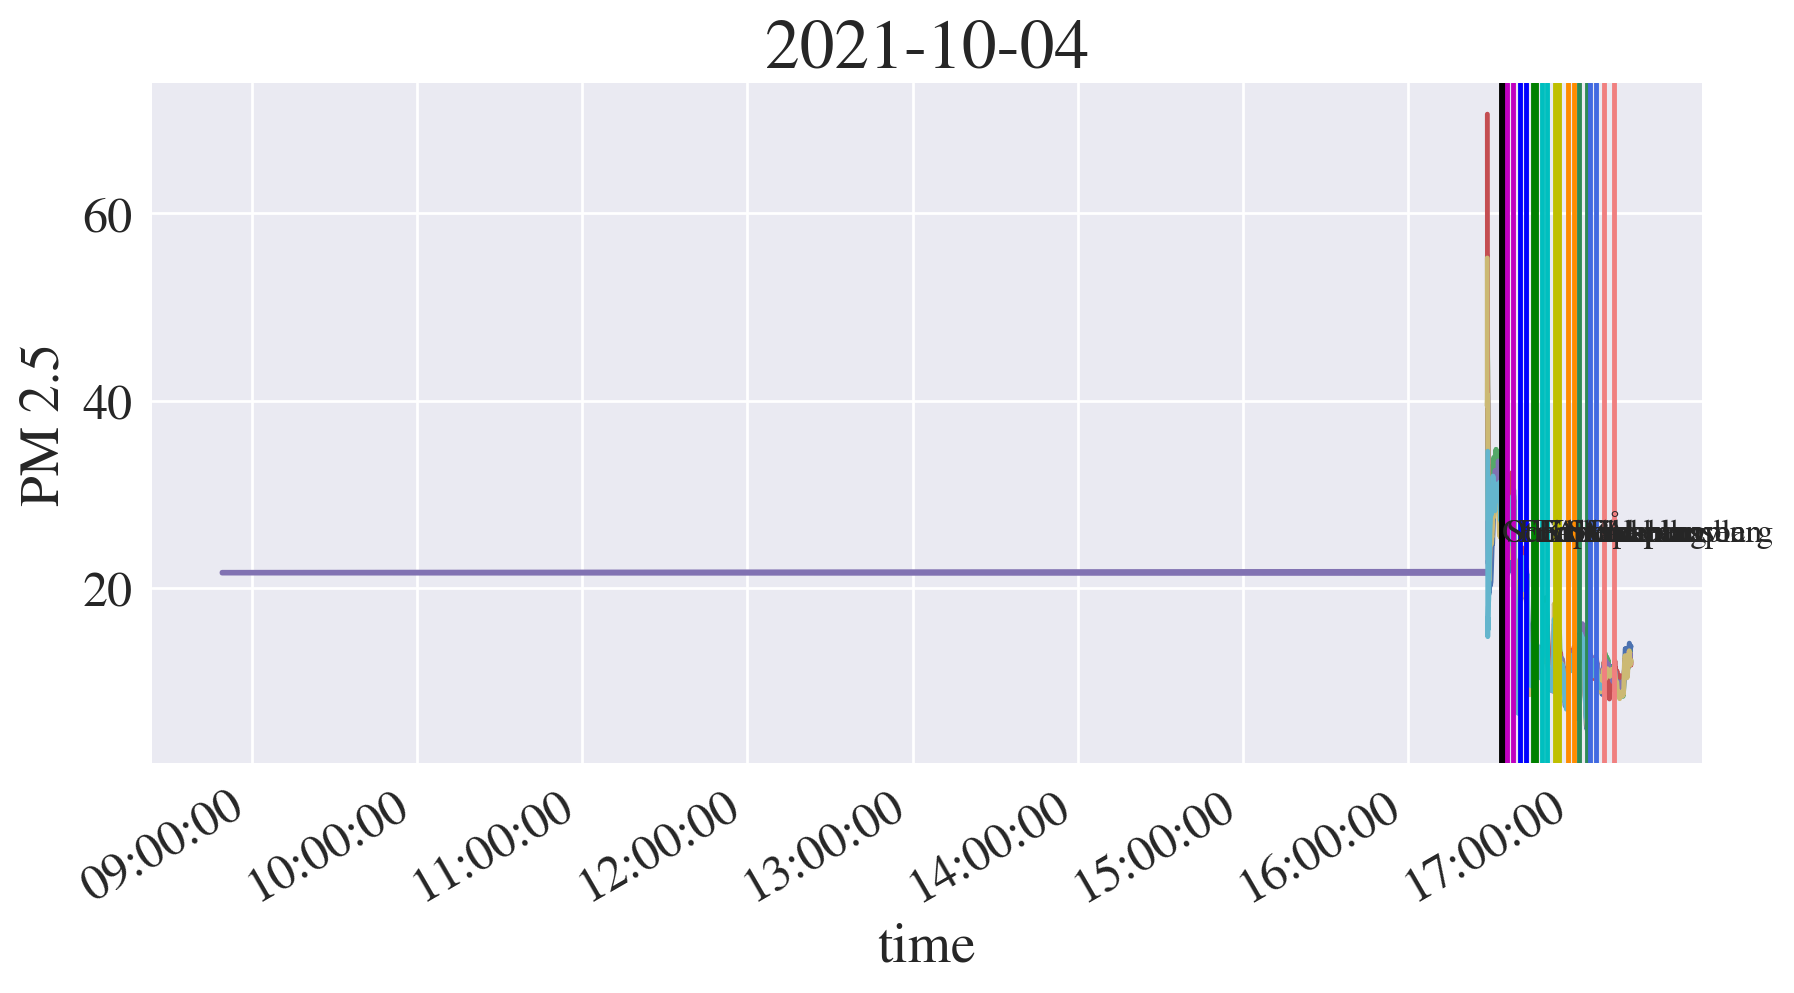

In [27]:
pt_df = get_placetime_df(placetimes_df, session['date'], session['route'], period)
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [28]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [29]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity   NC0.5  \
0    2021-10-04 16:35:55  St Eriksplan      1         24.4      55.2  107.58   
1    2021-10-04 16:35:55  St Eriksplan      2         24.3      55.8  115.52   
2    2021-10-04 16:35:55  St Eriksplan      3         24.7      53.8  134.06   
3    2021-10-04 16:35:55  St Eriksplan      4         24.5      54.9  113.95   
4    2021-10-04 16:35:55  St Eriksplan      5         24.5      54.0  112.63   
...                  ...           ...    ...          ...       ...     ...   
6388 2021-10-04 17:14:48       Åkeshov      1         25.9      46.7   73.50   
6389 2021-10-04 17:14:48       Åkeshov      2         25.3      50.2   70.27   
6390 2021-10-04 17:14:48       Åkeshov      3         27.7      43.0   70.86   
6391 2021-10-04 17:14:48       Åkeshov      4         26.6      45.4   66.99   
6392 2021-10-04 17:14:48       Åkeshov      5         26.0      46.0   72.51   

       NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0     132.37  137.65  138.74                 0.80  17.29  22.85  26.56  27.30   
1     143.09  149.03  150.22                 0.76  18.72  25.06  29.33  30.18   
2     162.42  167.52  168.54                 0.71  21.03  26.65  30.22  30.94   
3     140.12  145.76  146.90                 0.82  18.30  24.35  28.39  29.20   
4     136.85  141.27  142.18                 0.74  17.73  22.51  25.56  26.17   
...      ...     ...     ...                  ...    ...    ...    ...    ...   
6388   85.15   85.36   85.41                 0.57  10.70  11.31  11.31  11.31   
6389   81.78   81.99   82.03                 0.52  10.27  10.86  10.86  10.86   
6390   82.02   82.29   82.34                 0.50  10.31  10.93  10.96  10.96   
6391   77.48   77.71   77.75                 0.52   9.74  10.30  10.30  10.30   
6392   84.01   84.22   84.26                 0.51  10.55  11.16  11.16  11.16   

      Session Id  
0     20211004-2  
1     20211004-2  
2     20211004-2  
3     20211004-2  
4     20211004-2  
...          ...  
6388  20211004-2  
6389  20211004-2  
6390  20211004-2  
6391  20211004-2  
6392  20211004-2  

[6393 rows x 15 columns]

In [30]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR 2021-10-05

In [82]:
####################### PARAMETERS

date = '2021-10-05'
period = 'PM'

session_id = ''.join(date.split('-')) + '-4'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': 'ABCDE',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [97]:
manual_rows = [
    [date, 'AM', 'Rådmansgatan', '07:33:30', '07:35:30', 'Alicia', ''],
    [date, 'AM', 'Hötorget', '07:37:00', '07:39:00', 'Alicia', ''],
    [date, 'AM', 'T-Centralen', '07:41:00', '07:44:00', 'Alicia', ''],
    [date, 'AM', 'Östermalmstorg', '07:48:00', '07:53:00', 'Alicia', ''],
    [date, 'AM', 'Stadion', '07:54:00', '07:59:00', 'Alicia', ''],
    [date, 'AM', 'Tekniska Högskolan', '08:01:00', '08:07:00', 'Alicia', ''],
    [date, 'AM', 'Universitetet', '08:10:00', '08:16:00', 'Alicia', ''],
    [date, 'AM', 'Tekniska Högskolan', '08:18:00', '08:23:00', 'Alicia', ''],
    [date, 'AM', 'Stadion', '08:25:00', '08:31:00', 'Alicia', ''],
    [date, 'AM', 'Östermalmstorg', '08:33:00', '08:36:00', 'Alicia', ''],
    [date, 'PM', 'Odenplan', '15:03:30', '15:05:30', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

df_rows

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

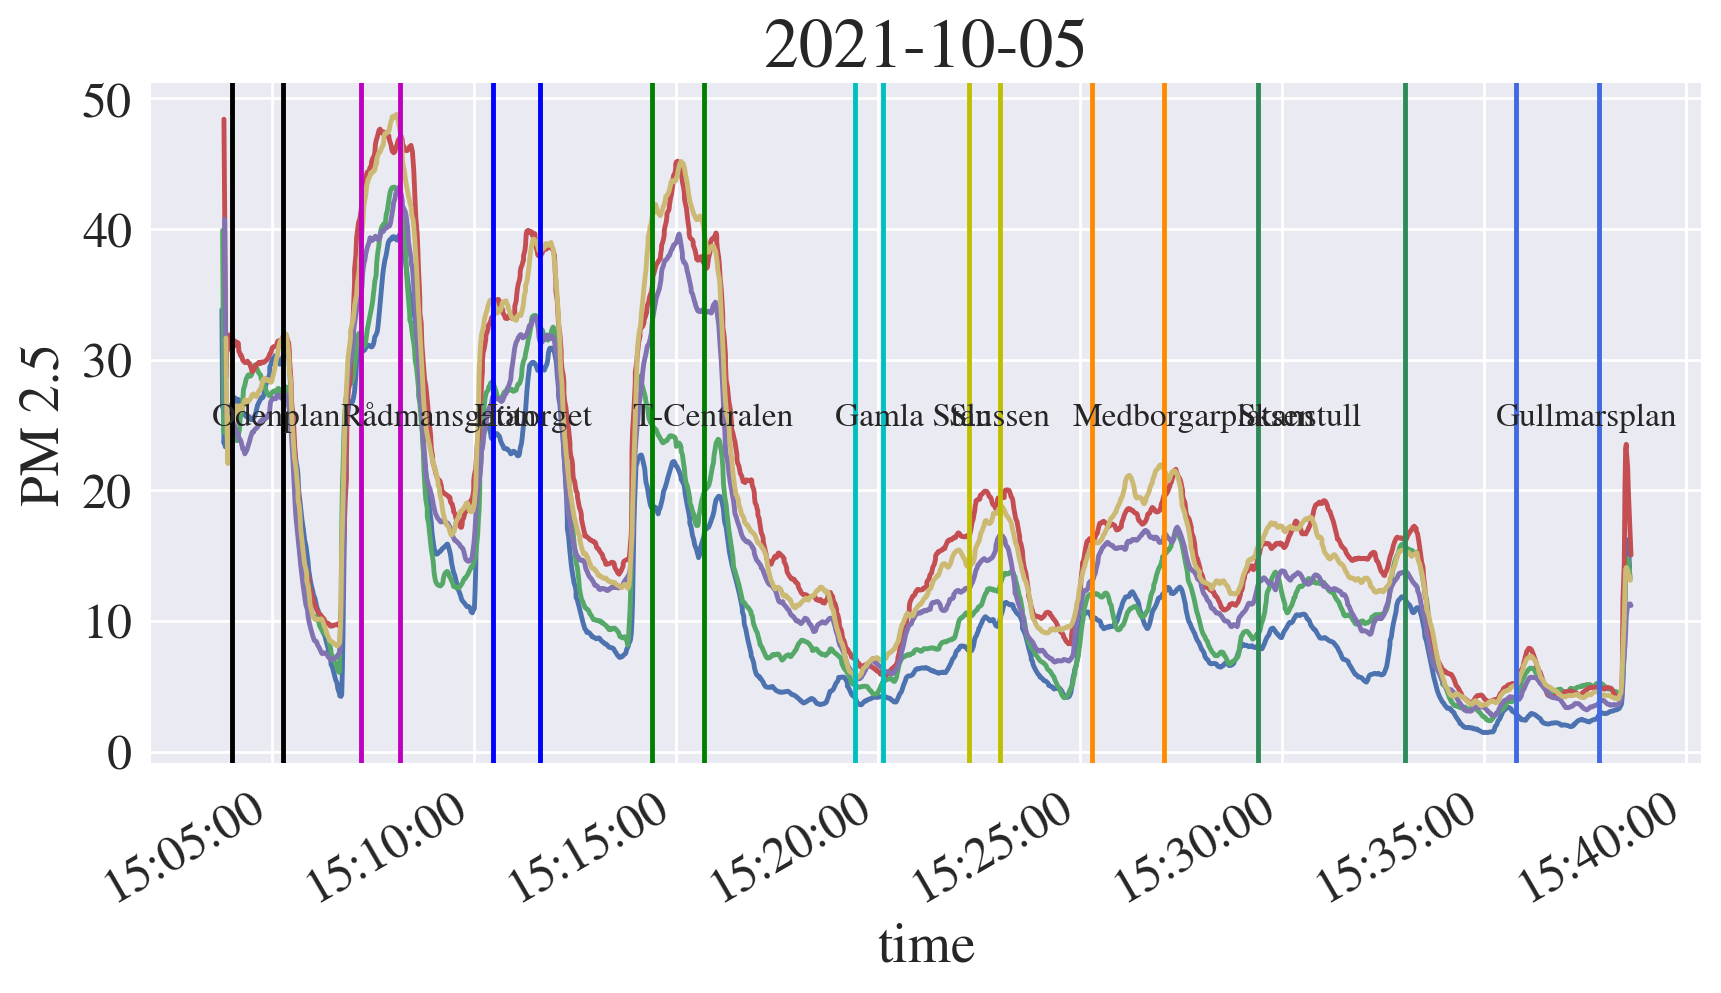

In [98]:
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
# ALICE AM pt_df = pt_df[:-2]

sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
# ALICE AM sensor_dfs = [sensor_dfs[1], sensor_dfs[2]]

session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [99]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [100]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-10-05 15:04:00      Odenplan      A         18.9      69.5  77.43   
1    2021-10-05 15:04:00      Odenplan      B         18.6      69.3  52.67   
2    2021-10-05 15:04:00      Odenplan      C         18.4      70.4  64.21   
3    2021-10-05 15:04:00      Odenplan      D         18.6      69.8  45.41   
4    2021-10-05 15:04:00      Odenplan      E         18.1      72.4  61.61   
...                  ...           ...    ...          ...       ...    ...   
3851 2021-10-05 15:37:51  Gullmarsplan      A         28.8      37.4  12.91   
3852 2021-10-05 15:37:51  Gullmarsplan      B         28.3      34.7  24.49   
3853 2021-10-05 15:37:51  Gullmarsplan      C         26.3      38.4  22.40   
3854 2021-10-05 15:37:51  Gullmarsplan      D         25.0      41.7  20.55   
3855 2021-10-05 15:37:51  Gullmarsplan      E         26.3      39.8  21.20   

       NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0     106.78  117.98  120.28                 0.91  14.87  25.82  34.00  35.63   
1      80.37   92.85   95.38                 1.09  11.73  24.09  33.55  35.44   
2     100.11  116.64  119.92                 1.13  14.74  31.26  43.95  46.48   
3      74.26   88.32   91.21                 1.16  11.17  24.63  35.00  37.08   
4      89.91  101.92  104.42                 1.02  12.86  24.55  33.42  35.20   
...      ...     ...     ...                  ...    ...    ...    ...    ...   
3851   16.01   16.72   16.87                 0.74   2.10   2.84   3.34   3.44   
3852   30.14   31.36   31.61                 0.72   3.94   5.25   6.13   6.30   
3853   27.68   28.90   29.14                 0.72   3.63   4.94   5.83   6.00   
3854   24.61   25.17   25.29                 0.68   3.16   3.81   4.19   4.26   
3855   26.05   27.06   27.27                 0.69   3.40   4.47   5.18   5.33   

      Session Id  
0     20211005-4  
1     20211005-4  
2     20211005-4  
3     20211005-4  
4     20211005-4  
...          ...  
3851  20211005-4  
3852  20211005-4  
3853  20211005-4  
3854  20211005-4  
3855  20211005-4  

[3856 rows x 15 columns]

In [101]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR: 2021-10-06

In [142]:
####################### PARAMETERS

date = '2021-10-06'
period = 'PM'

session_id = ''.join(date.split('-')) + '-4'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': '123456',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [143]:
placetimes_df.loc[(placetimes_df.station == 'Odenplan') & (placetimes_df.date == date)]

date period   station     start      stop   route mode
110  2021-10-06     AM  Odenplan  08:23:17  08:25:30  Alicia  NaN
111  2021-10-06     PM  Odenplan  18:12:16  18:16:18  Alicia  NaN

In [144]:
manual_rows = [
    [date, 'AM', 'Odenplan', '08:04:00', '08:06:00', 'Alice', ''],
    [date, 'PM', 'Odenplan', '18:12:00', '18:15:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

df_rows

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

In [145]:
# Add to placetimes
# placetimes_df = placetimes_df.append(df_rows)

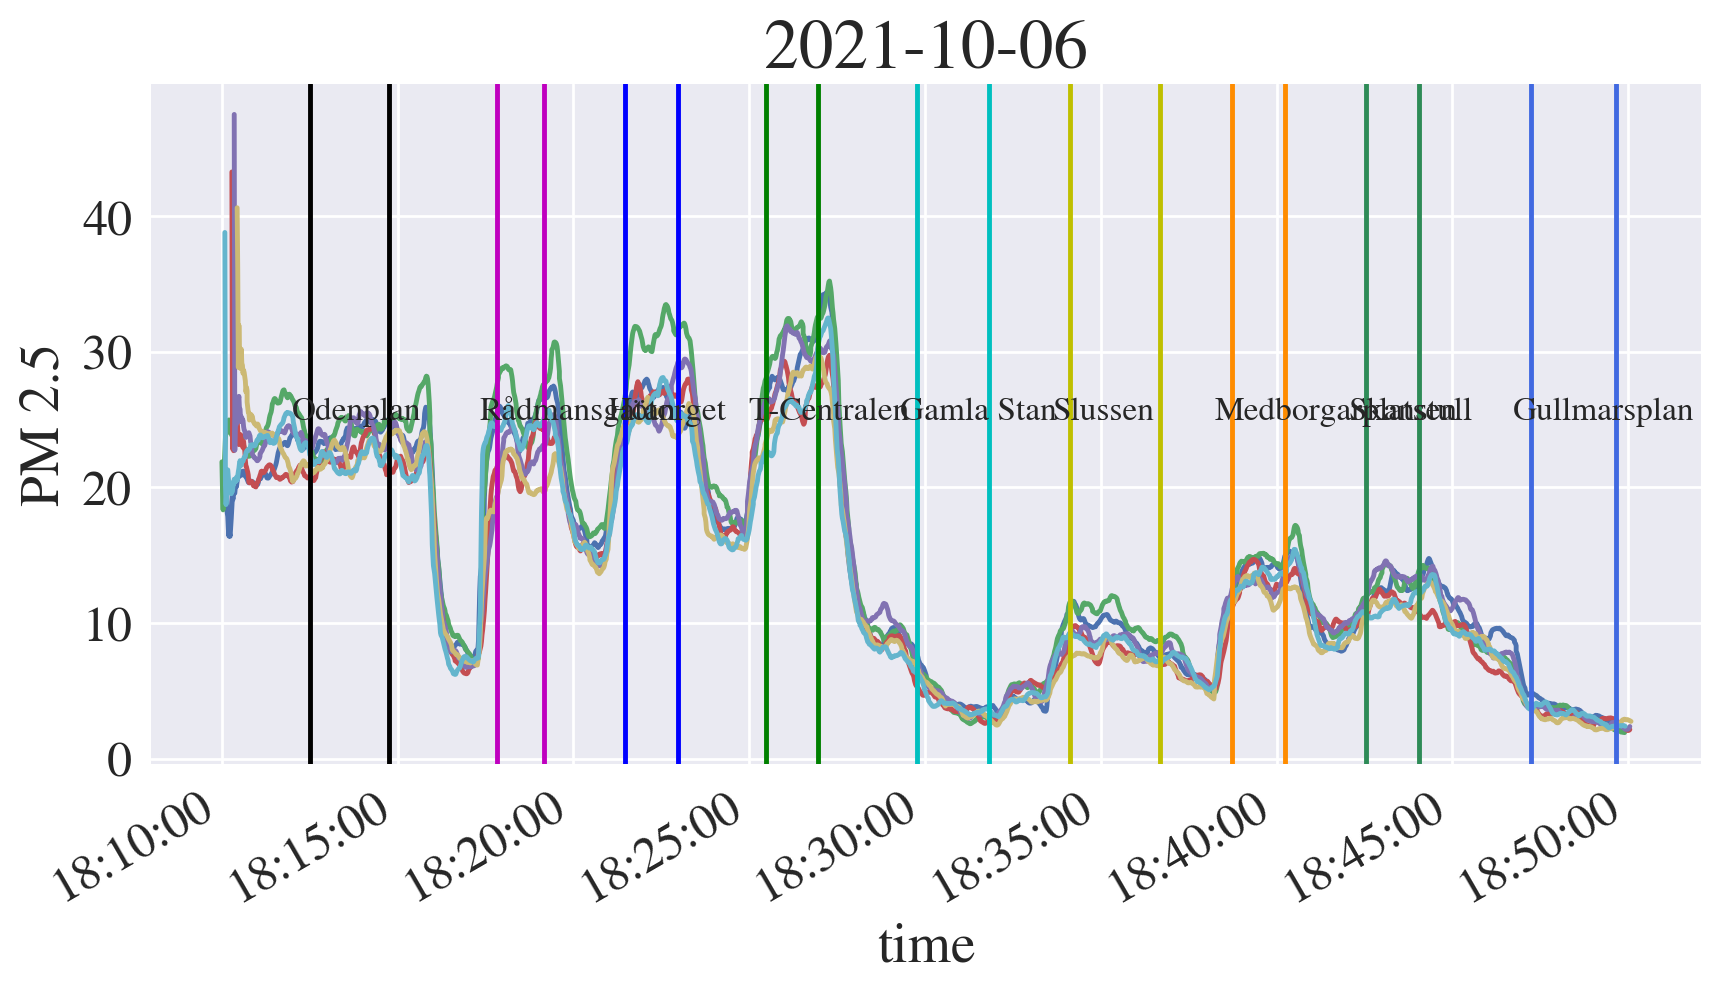

In [146]:
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
#pt_df = pt_df[1:]

sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [147]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [148]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-10-06 18:12:30      Odenplan      1         23.0      61.3  54.60   
1    2021-10-06 18:12:30      Odenplan      2         22.8      62.4  61.12   
2    2021-10-06 18:12:30      Odenplan      3         22.8      60.1  63.39   
3    2021-10-06 18:12:30      Odenplan      4         23.4      59.8  58.56   
4    2021-10-06 18:12:30      Odenplan      5         23.3      60.2  54.35   
...                  ...           ...    ...          ...       ...    ...   
5639 2021-10-06 18:49:39  Gullmarsplan      2         25.5      43.8   9.38   
5640 2021-10-06 18:49:39  Gullmarsplan      3         26.4      40.8  13.92   
5641 2021-10-06 18:49:39  Gullmarsplan      4         27.8      38.6  10.73   
5642 2021-10-06 18:49:39  Gullmarsplan      5         26.5      40.5  10.86   
5643 2021-10-06 18:49:39  Gullmarsplan      6         26.5      41.6   9.58   

      NC1.0  NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0     80.79  92.22   94.57                 1.05  11.64  22.68  31.08  32.76   
1     87.89  98.94  101.15                 0.98  12.48  23.42  31.69  33.34   
2     86.64  95.28   97.03                 0.90  12.00  20.70  27.18  28.47   
3     84.84  95.85   98.08                 1.03  12.09  23.07  31.39  33.05   
4     79.12  89.66   91.83                 1.02  11.31  21.52  29.26  30.81   
...     ...    ...     ...                  ...    ...    ...    ...    ...   
5639  11.73  12.28   12.39                 0.74   1.54   2.13   2.53   2.61   
5640  17.04  17.68   17.81                 0.71   2.22   2.91   3.36   3.45   
5641  13.52  14.26   14.41                 0.82   1.79   2.56   3.10   3.21   
5642  13.48  14.09   14.21                 0.79   1.77   2.40   2.83   2.91   
5643  12.27  13.05   13.21                 0.80   1.64   2.45   3.03   3.14   

      Session Id  
0     20211006-4  
1     20211006-4  
2     20211006-4  
3     20211006-4  
4     20211006-4  
...          ...  
5639  20211006-4  
5640  20211006-4  
5641  20211006-4  
5642  20211006-4  
5643  20211006-4  

[5644 rows x 15 columns]

In [149]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR: 2021-10-07

In [171]:
####################### PARAMETERS

date = '2021-10-07'
period = 'PM'

session_id = ''.join(date.split('-')) + '-4'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': 'ABCDE',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [172]:
manual_rows = [
    [date, 'AM', 'Odenplan', '08:04:00', '08:06:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

df_rows

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

In [173]:
# Add to placetimes
# placetimes_df = placetimes_df.append(df_rows)

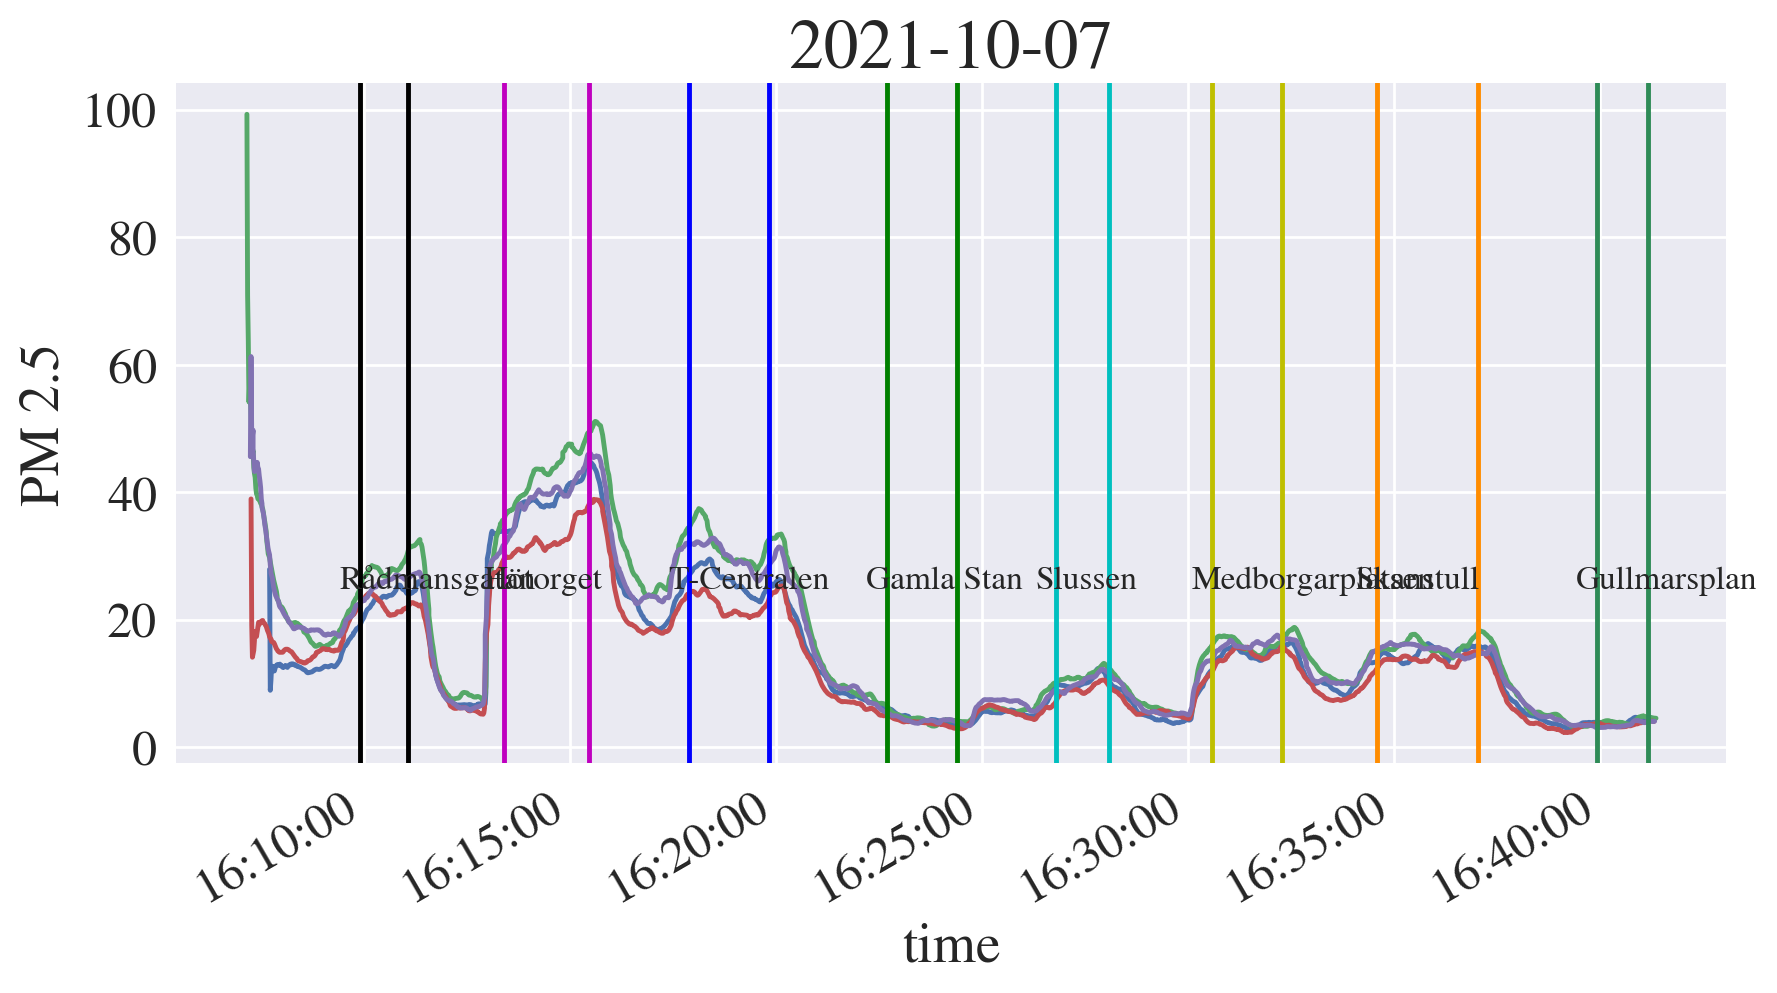

In [174]:
# Construct sensor files
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [175]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [176]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-10-07 16:09:54  Rådmansgatan      B         23.2      50.4  68.50   
1    2021-10-07 16:09:54  Rådmansgatan      C         22.9      50.6  75.04   
2    2021-10-07 16:09:54  Rådmansgatan      D         22.6      51.6  70.43   
3    2021-10-07 16:09:54  Rådmansgatan      E         22.9      52.0  69.40   
4    2021-10-07 16:09:55  Rådmansgatan      B         23.2      50.3  68.98   
...                  ...           ...    ...          ...       ...    ...   
3050 2021-10-07 16:41:08  Gullmarsplan      D         25.9      37.3  22.81   
3051 2021-10-07 16:41:08  Gullmarsplan      E         27.4      35.8  20.70   
3052 2021-10-07 16:41:09  Gullmarsplan      B         27.4      35.2  24.07   
3053 2021-10-07 16:41:09  Gullmarsplan      C         27.0      35.7  23.83   
3054 2021-10-07 16:41:09  Gullmarsplan      E         27.5      35.8  21.00   

       NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0      89.78   96.67   98.06                 0.91  12.16  19.20  24.32  25.35   
1     103.20  113.85  115.96                 0.92  14.35  25.16  33.24  34.85   
2      96.04  105.53  107.48                 0.95  13.29  22.60  29.52  30.90   
3      95.03  104.58  106.57                 0.91  13.17  22.59  29.59  30.99   
4      90.52   97.53   98.95                 0.92  12.27  19.43  24.64  25.69   
...      ...     ...     ...                  ...    ...    ...    ...    ...   
3050   27.03   27.49   27.59                 0.63   3.45   4.01   4.30   4.35   
3051   24.94   25.62   25.76                 0.62   3.21   3.97   4.43   4.52   
3052   28.72   29.36   29.49                 0.68   3.68   4.42   4.85   4.94   
3053   28.87   29.78   29.97                 0.64   3.74   4.76   5.41   5.55   
3054   25.29   25.97   26.11                 0.62   3.26   4.02   4.48   4.57   

      Session Id  
0     20211007-4  
1     20211007-4  
2     20211007-4  
3     20211007-4  
4     20211007-4  
...          ...  
3050  20211007-4  
3051  20211007-4  
3052  20211007-4  
3053  20211007-4  
3054  20211007-4  

[3055 rows x 15 columns]

In [177]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR: 2021-10-08

In [178]:
####################### PARAMETERS

date = '2021-10-08'
period = 'AM'

session_id = ''.join(date.split('-')) + '-1'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': 'ABCDE',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [179]:
# SPECIAL: ALICE DOES WHOLE ROUTE
placetimes_df.loc[placetimes_df.date == date, 'route'] = 'Alice'

placetimes_df[placetimes_df['date'] == date].head(20)

date period           station     start      stop  route mode
212  2021-10-08     AM             Alvik  08:20:46  08:22:41  Alice  NaN
213  2021-10-08     AM      Fridhemsplan  08:09:25  08:11:30  Alice  NaN
214  2021-10-08     AM        Gamla Stan  07:46:53  07:48:25  Alice  NaN
215  2021-10-08     AM      Gullmarsplan  07:27:12  07:28:04  Alice  NaN
216  2021-10-08     AM          Hötorget  07:53:56  07:56:18  Alice  NaN
217  2021-10-08     AM      Kristineberg  08:16:11  08:18:32  Alice  NaN
218  2021-10-08     AM  Medborgarplatsen  07:34:58  07:39:37  Alice  NaN
219  2021-10-08     AM          Odenplan  08:02:04  08:03:50  Alice  NaN
220  2021-10-08     AM      Rådmansgatan  07:58:13  07:59:46  Alice  NaN
221  2021-10-08     AM         Skanstull  07:30:49  07:33:23  Alice  NaN
222  2021-10-08     AM           Slussen  07:41:24  07:45:05  Alice  NaN
223  2021-10-08     AM      St Eriksplan  08:06:01  08:07:30  Alice  NaN
224  2021-10-08     AM       T-Centralen  07:50:59  07:52:13  Alice  NaN
225  2021-10-08     AM      Thorildsplan  08:13:29  08:14:45  Alice  NaN

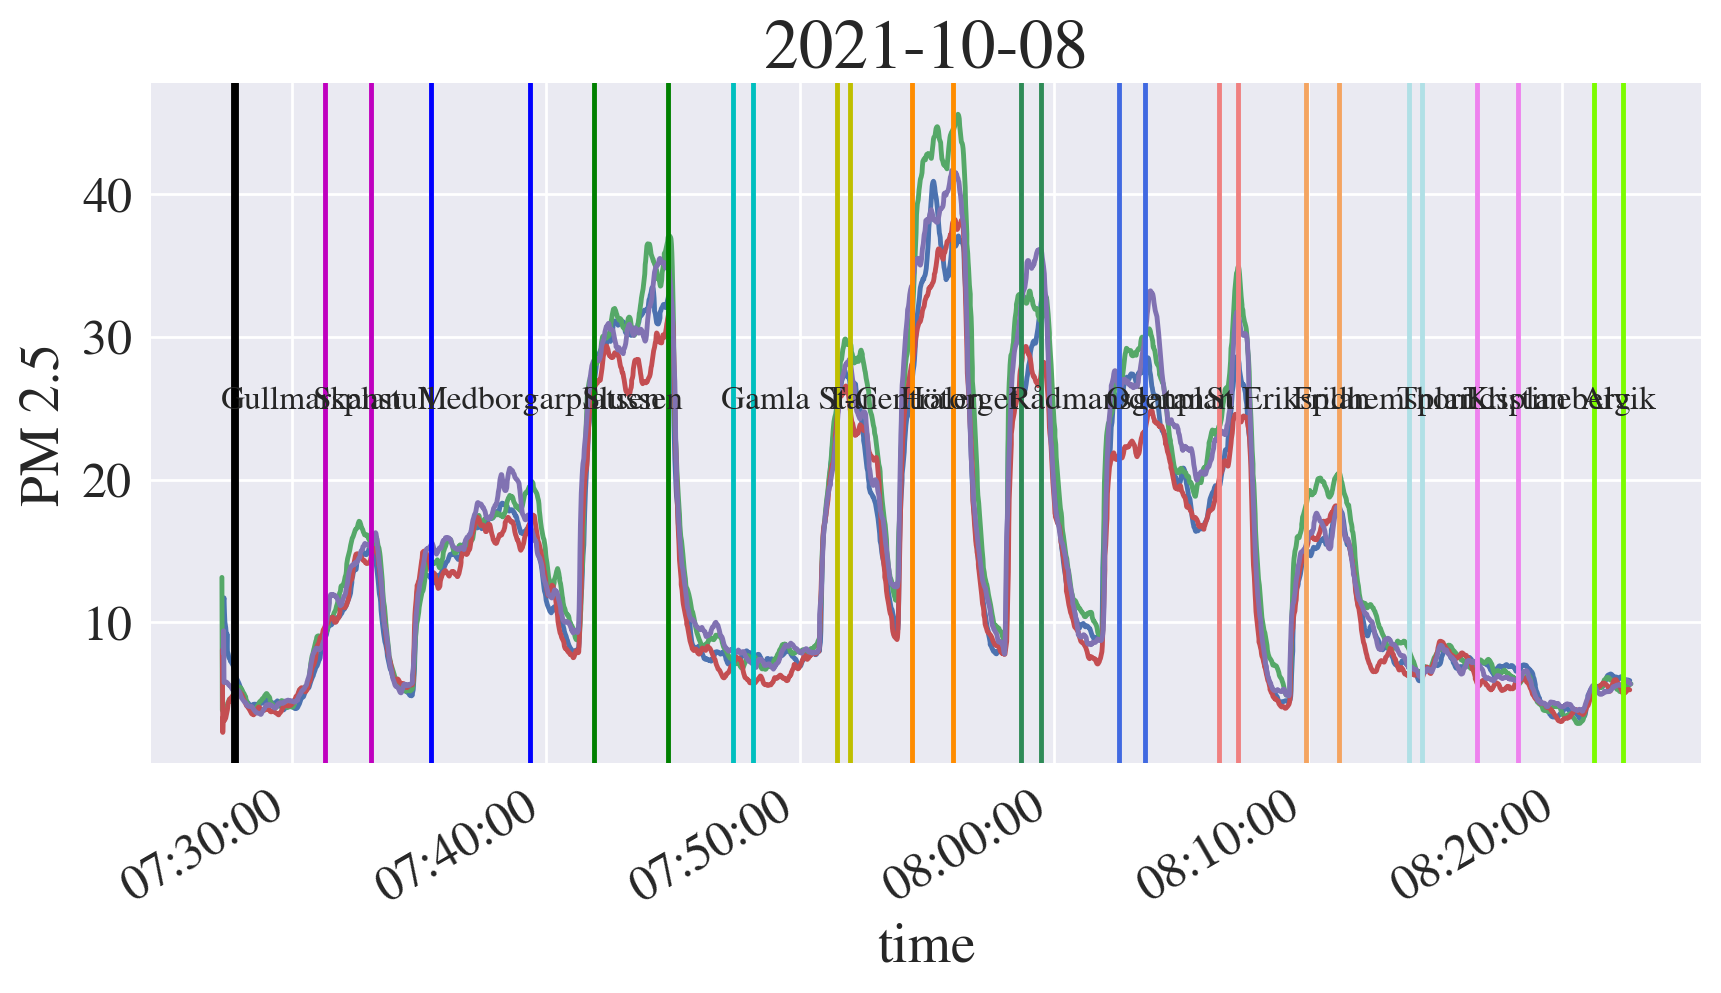

In [180]:
# Construct sensor files
pt_df = get_placetime_df(placetimes_df, session['date'], session['route'], period)
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [181]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [182]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-10-08 07:27:42  Gullmarsplan      B         20.5      46.0  45.08   
1    2021-10-08 07:27:42  Gullmarsplan      C         20.7      44.6  31.31   
2    2021-10-08 07:27:42  Gullmarsplan      D         19.6      48.3  29.23   
3    2021-10-08 07:27:42  Gullmarsplan      E         20.4      47.0  34.25   
4    2021-10-08 07:27:43  Gullmarsplan      B         20.5      46.0  44.35   
...                  ...           ...    ...          ...       ...    ...   
4262 2021-10-08 08:22:25         Alvik      E         23.9      38.7  36.91   
4263 2021-10-08 08:22:26         Alvik      B         25.3      35.3  39.71   
4264 2021-10-08 08:22:26         Alvik      C         23.8      37.7  35.66   
4265 2021-10-08 08:22:26         Alvik      D         24.4      36.7  32.68   
4266 2021-10-08 08:22:26         Alvik      E         23.9      38.7  37.46   

      NC1.0  NC2.5   NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0  PM10  \
0     52.15  52.30  52.33                 0.53   6.55   6.93   6.93  6.93   
1     36.16  36.26  36.28                 0.49   4.54   4.80   4.80  4.80   
2     34.34  34.73  34.81                 0.63   4.35   4.88   5.11  5.16   
3     39.67  39.77  39.78                 0.42   4.98   5.27   5.27  5.27   
4     51.31  51.46  51.48                 0.52   6.45   6.82   6.82  6.82   
...     ...    ...    ...                  ...    ...    ...    ...   ...   
4262  42.75  42.86  42.87                 0.49   5.37   5.68   5.68  5.68   
4263  45.93  46.06  46.09                 0.52   5.77   6.10   6.10  6.10   
4264  41.19  41.30  41.32                 0.45   5.18   5.47   5.47  5.47   
4265  37.86  37.96  37.98                 0.52   4.76   5.03   5.03  5.03   
4266  43.39  43.50  43.52                 0.49   5.45   5.76   5.76  5.76   

      Session Id  
0     20211008-1  
1     20211008-1  
2     20211008-1  
3     20211008-1  
4     20211008-1  
...          ...  
4262  20211008-1  
4263  20211008-1  
4264  20211008-1  
4265  20211008-1  
4266  20211008-1  

[4267 rows x 15 columns]

In [183]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR 2021-10-11

In [203]:
####################### PARAMETERS

date = '2021-10-11'
period = 'PM'

session_id = ''.join(date.split('-')) + '-4'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': '123456',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

####################### PARAMETERS

In [215]:
manual_rows = [
    [date, 'PM', 'Odenplan', '16:57:00', '17:00:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

df_rows

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

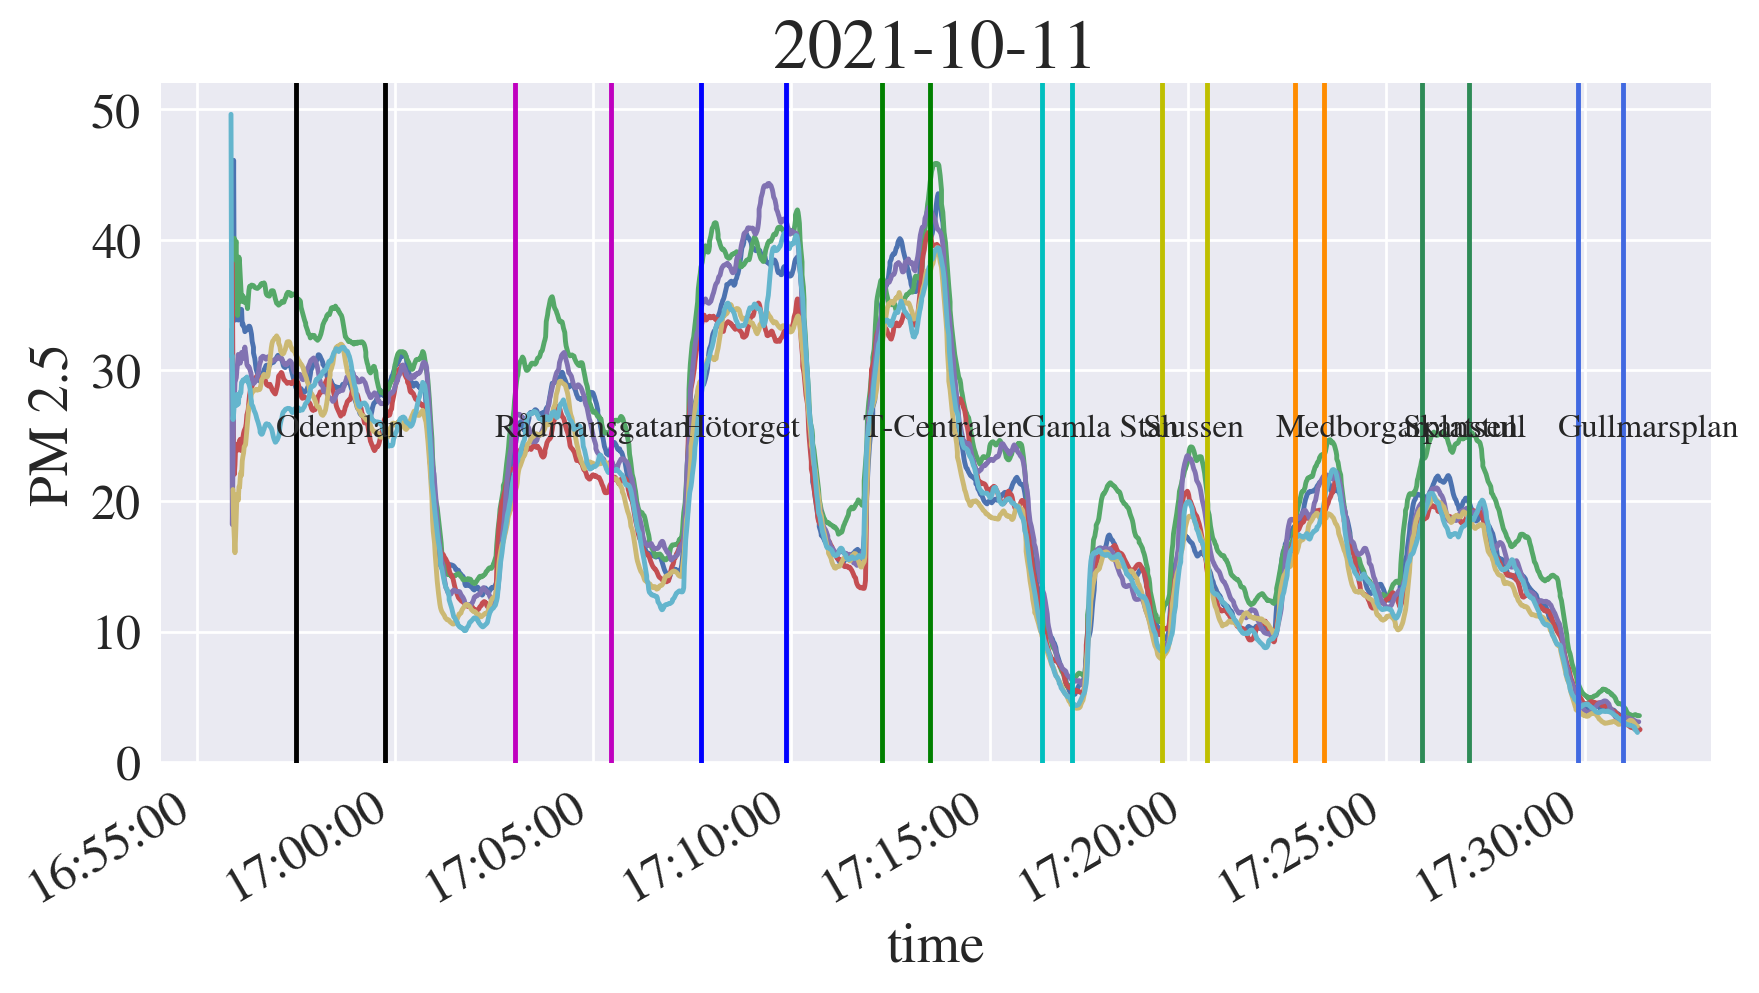

In [216]:
# Construct sensor files
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [217]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [218]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-10-11 16:57:30      Odenplan      1         21.8      50.3  66.40   
1    2021-10-11 16:57:30      Odenplan      2         21.9      50.0  81.17   
2    2021-10-11 16:57:30      Odenplan      3         21.9      49.2  82.24   
3    2021-10-11 16:57:30      Odenplan      5         21.8      49.4  69.95   
4    2021-10-11 16:57:30      Odenplan      6         21.7      50.3  72.53   
...                  ...           ...    ...          ...       ...    ...   
4391 2021-10-11 17:30:58  Gullmarsplan      2         24.8      32.7  13.98   
4392 2021-10-11 17:30:58  Gullmarsplan      3         26.2      30.3  13.33   
4393 2021-10-11 17:30:58  Gullmarsplan      4         26.4      30.3  12.50   
4394 2021-10-11 17:30:58  Gullmarsplan      5         25.4      31.2  12.55   
4395 2021-10-11 17:30:58  Gullmarsplan      6         24.3      33.3  12.32   

       NC1.0   NC2.5    NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0   PM10  \
0      99.62  114.39  117.43                 1.08  14.44  28.70  39.56  41.73   
1     122.35  140.69  144.36                 1.00  17.77  35.80  49.57  52.32   
2     115.20  128.18  130.80                 0.90  16.16  29.15  38.91  40.87   
3     106.10  122.41  125.76                 1.10  15.46  31.17  43.17  45.57   
4     103.30  115.83  118.36                 0.97  14.61  27.11  36.56  38.44   
...      ...     ...     ...                  ...    ...    ...    ...    ...   
4391   18.88   20.62   20.97                 0.87   2.60   4.34   5.63   5.89   
4392   16.86   17.82   18.02                 0.76   2.24   3.24   3.94   4.08   
4393   16.23   17.40   17.63                 0.86   2.19   3.38   4.24   4.42   
4394   15.84   16.72   16.90                 0.84   2.10   2.99   3.62   3.74   
4395   15.68   16.62   16.81                 0.80   2.09   3.07   3.76   3.90   

      Session Id  
0     20211011-4  
1     20211011-4  
2     20211011-4  
3     20211011-4  
4     20211011-4  
...          ...  
4391  20211011-4  
4392  20211011-4  
4393  20211011-4  
4394  20211011-4  
4395  20211011-4  

[4396 rows x 15 columns]

In [219]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR 2021-10-12

In [281]:
####################### PARAMETERS

date = '2021-10-12'
period = 'AM'

session_id = ''.join(date.split('-')) + '-1'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': '123456',
}

####################### PARAMETERS

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

In [282]:
manual_rows = [
    [date, 'PM', 'St Eriksplan', '19:12:00', '19:13:00', 'Alicia', ''],
    [date, 'PM', 'Fridhemsplan', '19:16:00', '19:18:00', 'Alicia', ''],
    [date, 'PM', 'Thorildsplan', '19:19:00', '19:23:00', 'Alicia', ''],
    [date, 'PM', 'Kristineberg', '19:24:00', '19:27:00', 'Alicia', ''],
    [date, 'PM', 'Alvik', '19:31:00', '19:33:00', 'Alicia', ''],
    [date, 'PM', 'Åkeshov', '19:41:00', '19:48:00', 'Alicia', ''],
    [date, 'PM', 'Rådmansgatan', '17:26:00', '17:28:00', 'Alice', ''],
    [date, 'PM', 'Hötorget', '17:30:00', '17:32:00', 'Alice', ''],
    [date, 'PM', 'T-Centralen', '17:33:00', '17:37:00', 'Alice', ''],
    [date, 'PM', 'Gamla Stan', '17:39:00', '17:42:00', 'Alice', ''],
    [date, 'PM', 'Slussen', '17:43:00', '17:45:00', 'Alice', ''],
    [date, 'PM', 'Medborgarplatsen', '17:48:00', '17:52:00', 'Alice', ''],
    [date, 'PM', 'Skanstull', '17:53:00', '17:55:00', 'Alice', ''],
    [date, 'PM', 'Gullmarsplan', '17:57:00', '18:00:00', 'Alice', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

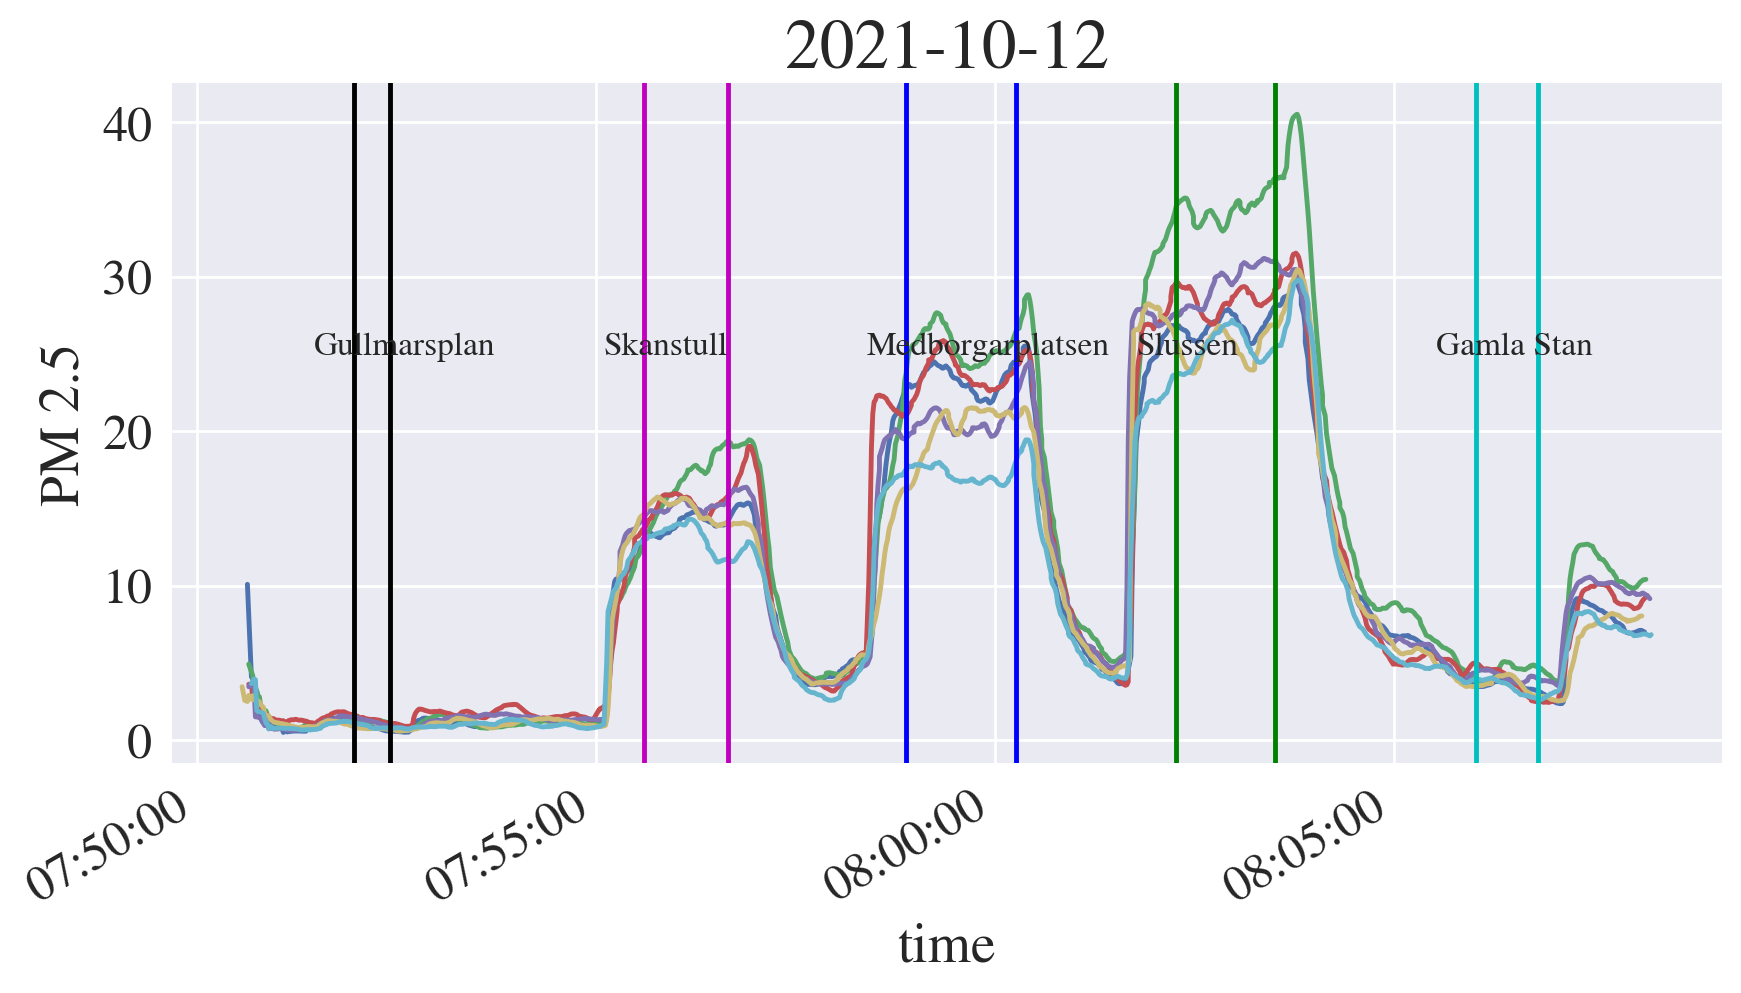

In [283]:
# Construct sensor files
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [284]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [285]:
session_chunk

Timestamp       Station Sensor  Temperature  Humidity  NC0.5  \
0    2021-10-12 07:51:58  Gullmarsplan      1         18.5      38.3   4.97   
1    2021-10-12 07:51:58  Gullmarsplan      2         17.9      39.9   5.44   
2    2021-10-12 07:51:58  Gullmarsplan      3         17.9      39.7   5.45   
3    2021-10-12 07:51:58  Gullmarsplan      4         18.8      38.1   5.55   
4    2021-10-12 07:51:58  Gullmarsplan      5         18.4      38.1   4.44   
...                  ...           ...    ...          ...       ...    ...   
1671 2021-10-12 08:06:48    Gamla Stan      1         22.2      31.9   7.93   
1672 2021-10-12 08:06:48    Gamla Stan      2         21.7      33.0   9.81   
1673 2021-10-12 08:06:48    Gamla Stan      4         22.4      32.0   9.25   
1674 2021-10-12 08:06:48    Gamla Stan      5         21.8      31.9   6.47   
1675 2021-10-12 08:06:48    Gamla Stan      6         20.8      34.3   6.11   

      NC1.0  NC2.5   NC10  TypicalParticleSize  PM1.0  PM2.5  PM4.0  PM10  \
0      6.23   6.55   6.62                 0.71   0.82   1.15   1.38  1.43   
1      6.86   7.22   7.29                 0.76   0.91   1.28   1.54  1.60   
2      7.26   7.89   8.01                 0.83   0.99   1.62   2.09  2.18   
3      7.22   7.75   7.86                 0.83   0.98   1.52   1.91  1.99   
4      5.38   5.55   5.59                 0.78   0.70   0.88   1.00  1.02   
...     ...    ...    ...                  ...    ...    ...    ...   ...   
1671  11.60  13.17  13.49                 1.06   1.66   3.18   4.33  4.56   
1672  15.29  17.84  18.35                 1.03   2.25   4.75   6.66  7.04   
1673  13.80  15.80  16.20                 1.07   1.99   3.98   5.49  5.79   
1674   9.75  11.21  11.52                 1.06   1.42   2.83   3.91  4.12   
1675   9.13  10.46  10.73                 0.99   1.32   2.64   3.64  3.84   

      Session Id  
0     20211012-1  
1     20211012-1  
2     20211012-1  
3     20211012-1  
4     20211012-1  
...          ...  
1671  20211012-1  
1672  20211012-1  
1673  20211012-1  
1674  20211012-1  
1675  20211012-1  

[1676 rows x 15 columns]

In [286]:
# SAVE SESSION TO FILE
folder = f'sessions_NC/{date}'

if not os.path.exists(folder):
    os.makedirs(folder)

session_chunk.to_csv(f'{folder}/{session_id}.csv')

## KLAR: 2021-10-13

In [293]:
####################### PARAMETERS

date = '2021-10-13'
period = 'PM'

session_id = ''.join(date.split('-')) + '-2'

session = {
    'date': date,
    'route': 'Alicia',
    'sensors': '123456',
}

####################### PARAMETERS

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

if not os.path.exists(folder):
    os.makedirs(folder)
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

In [294]:

manual_rows = [
    [date, 'AM', 'Alvik', '09:08:00', '09:10:00', 'Alicia', ''],
    [date, 'AM', 'Kristineberg', '09:13:00', '09:15:00', 'Alicia', ''],
    [date, 'AM', 'Thorildsplan', '09:16:00', '09:18:00', 'Alicia', ''],
    [date, 'AM', 'Fridhemsplan', '09:20:00', '09:24:00', 'Alicia', ''],
    [date, 'AM', 'St Eriksplan', '09:26:00', '09:28:00', 'Alicia', ''],
    [date, 'AM', 'Odenplan', '09:30:00', '09:32:00', 'Alicia', ''],
    [date, 'PM', 'Odenplan', '15:30:00', '15:32:00', 'Alicia', ''],
    [date, 'PM', 'St Eriksplan', '15:34:00', '15:36:00', 'Alicia', ''],
    [date, 'PM', 'Fridhemsplan', '15:37:00', '15:40:00', 'Alicia', ''],
    [date, 'PM', 'Thorildsplan', '15:42:00', '15:44:00', 'Alicia', ''],
    [date, 'PM', 'Kristineberg', '15:45:00', '15:48:00', 'Alicia', ''],
    [date, 'PM', 'Alvik', '15:50:00', '15:52:00', 'Alicia', ''],
    [date, 'PM', 'Stora mossen', '15:55:00', '15:57:00', 'Alicia', ''],
    [date, 'PM', 'Abrahamsberg', '15:59:00', '16:03:00', 'Alicia', ''],
    [date, 'PM', 'Brommaplan', '16:04:00', '16:06:00', 'Alicia', ''],
]

df_rows = pd.DataFrame(manual_rows, columns=['date', 'period', 'station', 'start', 'stop', 'route', 'mode'])

# Add to placetimes
placetimes_df_copy = placetimes_df.copy()

placetimes_df_copy = placetimes_df_copy.append(df_rows)

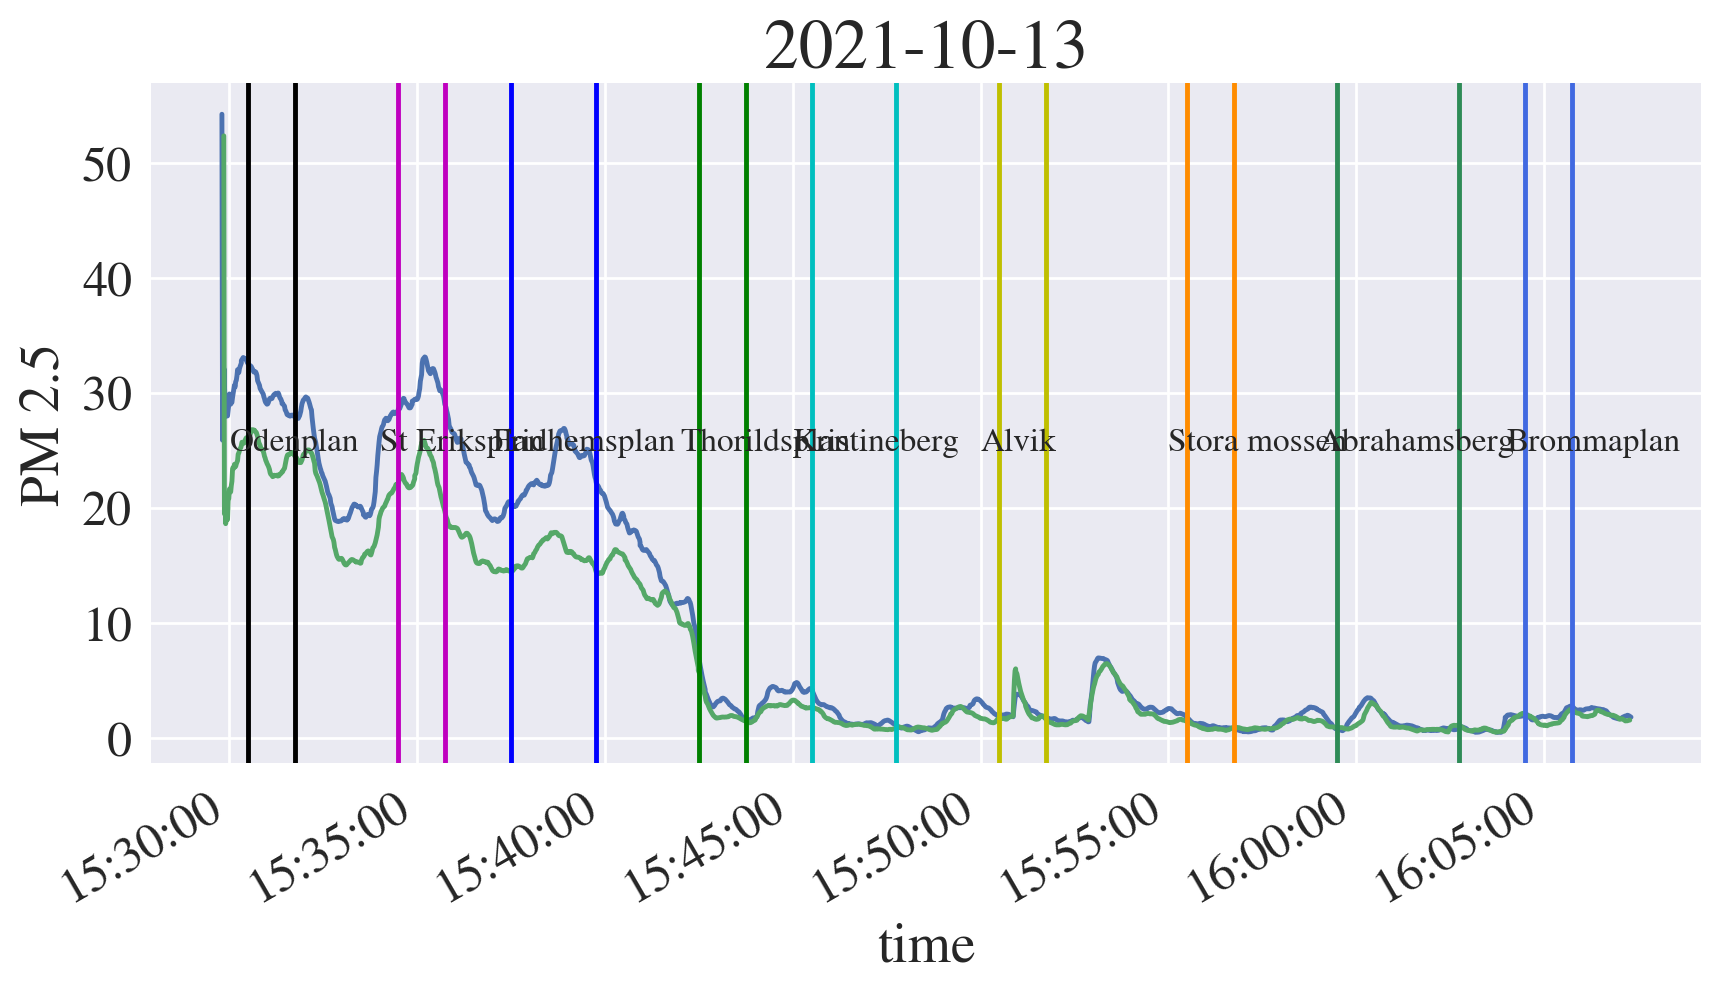

In [295]:
# Construct sensor files
pt_df = get_placetime_df(placetimes_df_copy, session['date'], session['route'], period)
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

# Plot
filename = fig_folder + '/' + session_id + '.pdf'
plot_sensors(date, sensor_dfs, labels, pt_df, OFFSETS, filename)

Happy with the plot?

In [296]:
# Get station chunks
o1, o2 = OFFSETS

# All station chunks
session_chunks = []

for index, row in pt_df.iterrows():
    start = get_timestamp(row['start'], row['date'], o1)
    stop = get_timestamp(row['stop'], row['date'], o2)

    # Get station dataframe and convert into arrays
    station_chunks = get_station_chunks(date, row['station'], start, stop, pt_df, sensor_dfs, OFFSETS)
    
    # Combine station_chunks into session chunk
    station_chunk = pd.concat(station_chunks)

    # Sort by column
    station_chunk = station_chunk.sort_values(by=['Timestamp', 'Sensor'], ascending=[True, True])

    # Remove old index column
    station_chunk.reset_index(drop=True, inplace=True)

    session_chunks.append(station_chunk)

# Combine
session_chunk = pd.concat(session_chunks)

# Sort by column
#session_chunk = session_chunk.sort_values(by=['Timestamp'], ascending=[True])

# Remove old index column
session_chunk.reset_index(drop=True, inplace=True)

session_chunk['Session Id'] = session_id

In [297]:
# SAVE SESSION TO FILE
session_chunk.to_csv(f'{folder}/{session_id}.csv')

In [298]:
# SAVE SESSION TO FILE
folder = f'sessions_NC/{date}'

if not os.path.exists(folder):
    os.makedirs(folder)

session_chunk.to_csv(f'{folder}/{session_id}.csv')

/var/folders/3g/v1w6md6j2ks3gkj815wym0br0000gn/T/ipykernel_30583/1607674521.py:45: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pt_df = pt_df.drop('mode', 1)


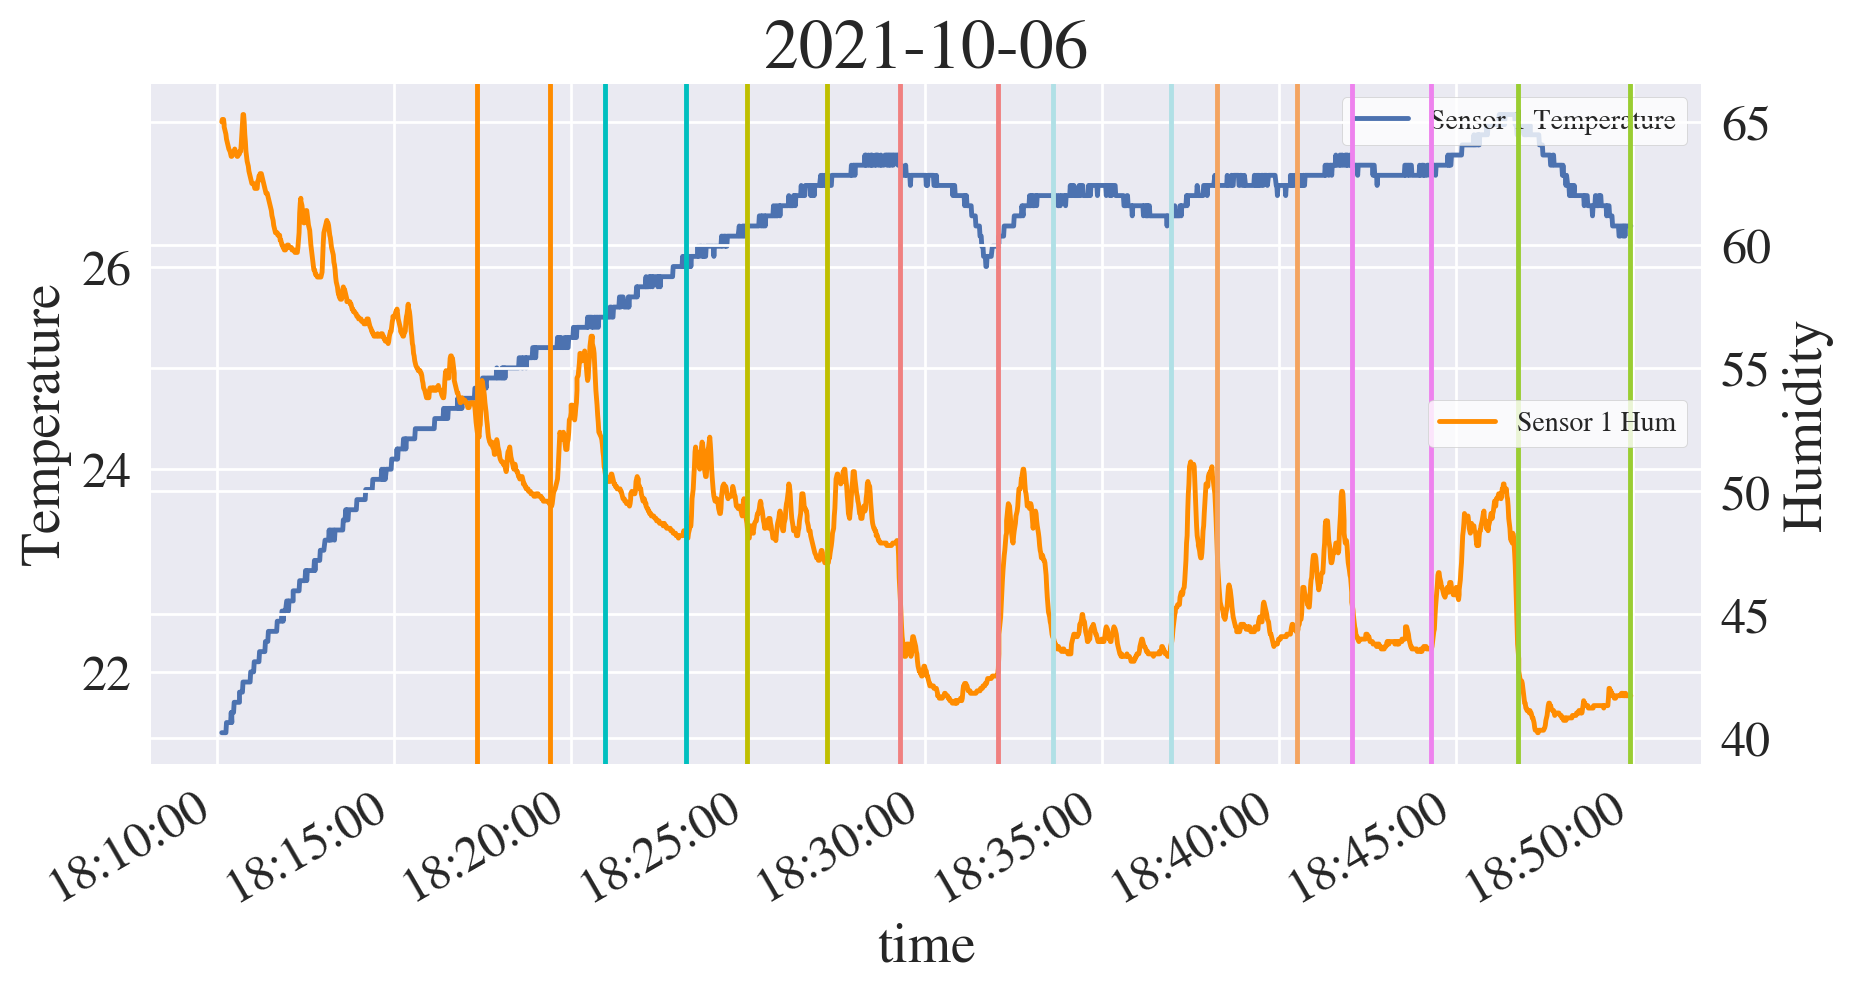

In [88]:
def plot_NC(date, dfs, labels, pt_df, offsets=(0,0), filename=None):
    # Plot to determine route
    fig, ax = plt.subplots(dpi=200, figsize = (10, 5))
    ax2=ax.twinx()

    for i, df in enumerate(dfs):
        # NUMBER COUNT
        #ax.plot(df['Timestamp'], df['NC0.5'], label=f'Sensor {labels[i]} NC0.5')
        #ax.plot(df['Timestamp'], df['NC1.0'], label=f'Sensor {labels[i]} NC1.0')
        #ax.plot(df['Timestamp'], df['NC2.5'], label=f'Sensor {labels[i]} NC2.5')
        ax.plot(df['Timestamp'], df['Temperature'], label=f'Sensor {labels[i]} Temperature')
        
        # TEMPERATURE
        
        #ax2.plot(df['Timestamp'], df['PM2.5'], label=f'Sensor {labels[i]} PM2.5', color='darkorange')
        #ax2.set_ylabel("PM2.5")
        ax2.plot(df['Timestamp'], df['Humidity'], label=f'Sensor {labels[i]} Hum', color='darkorange')
        break
    
    ax2.set_ylabel("Humidity")
    
    colors = ['darkorange', 'c', 'y', 'lightcoral', 'powderblue', 'sandybrown', 'violet', 'yellowgreen', 'goldenrod', 'k', 'b', 'g', 'darkorange', 'b']
    
    # Plot start and stop as vertical lines
    i = 0
    for index, row in pt_df.iterrows():
        
        # Check if lines need offsetting
        try:
            o1, o2 = offsets
            plt.axvline(x=get_timestamp(row['start'], date, o1), color=colors[i])
            plt.axvline(x=get_timestamp(row['stop'], date, o2), color=colors[i])
            i += 1 
        except:  
            i += 1   
    
    # Label axis
    ax.set_title(f'{date}', fontsize=25)
    ax.set_xlabel('time')
    ax.set_ylabel('Temperature')
    #ax.set_ylabel('NC2.5')
    ax.legend(fontsize=10, loc=1, frameon=True, facecolor='#fff')
    ax2.legend(fontsize=10, loc=5, frameon=True, facecolor='#fff')
    # Format time on x-axis
    plt.gcf().autofmt_xdate()
    myFmt = dates.DateFormatter('%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(myFmt)
    
    if not filename == None:
        plt.savefig(filename)

    plt.show()

####################### PARAMETERS

date = '2021-10-06'
period = 'PM'

session = {
    'date': date,
    'route': 'Alice',
    'sensors': '123456',
}

folder = f'sessions_NC/{date}'
fig_folder = folder + '/' + '_figures'

####################### PARAMETERS

pt_df = get_placetime_df(placetimes_df, session['date'], session['route'], period)
sensor_dfs, labels, files = get_sensor_dfs(date, session['sensors'], period)
session['files'] = files

plot_NC(date, sensor_dfs, labels, pt_df)

In [58]:
len(sensor_dfs)

1